#### Writeup at the end of each problem in comments

# Problem 1

In [43]:
# !pip install -q transformers

In [44]:
from transformers import GPT2LMHeadModel, GPT2TokenizerFast
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [45]:
device = "cuda"

In [46]:
test = pd.read_csv('Problem1_dataset.csv')

In [47]:
print('First 10 test samples:')
for i, example in enumerate(test.text.values[:10]):
  print(f'{i+1}. {example}')

First 10 test samples:
1.  = Robert Boulter = 

2.  Robert Boulter is an English film , television and theatre actor . He had a guest @-@ starring role on the television series The Bill in 2000 . This was followed by a starring role in the play Herons written by Simon Stephens , which was performed in 2001 at the Royal Court Theatre . He had a guest role in the television series Judge John Deed in 2002 . In 2004 Boulter landed a role as " Craig " in the episode " Teddy 's Story " of the television series The Long Firm ; he starred alongside actors Mark Strong and Derek Jacobi . He was cast in the 2005 theatre productions of the Philip Ridley play Mercury Fur , which was performed at the Drum Theatre in Plymouth and the Menier Chocolate Factory in London . He was directed by John Tiffany and starred alongside Ben Whishaw , Shane Zaza , Harry Kent , Fraser Ayres , Sophie Stanton and Dominic Hall . 

3.  In 2006 , Boulter starred alongside Whishaw in the play Citizenship written by Mark R

In [48]:
# Print dataset statistics:
NoOfSamples = test.describe()['text'].iloc[0]

NoOfCharecters = sum(test['text'].map(lambda calc: len(calc)))

AvgCharecters = NoOfCharecters / NoOfSamples

In [49]:
print(f"The dataset has a total of {NoOfSamples} samples")
print(f"The sample has on average a total of {AvgCharecters:.2f} charecters")

The dataset has a total of 187 samples
The sample has on average a total of 483.80 charecters


In [50]:
# Get Tokenizer
tokenizer = GPT2TokenizerFast.from_pretrained("openai-community/gpt2")

# Get Models
model_small = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")
model_small.to(device)
model_small.eval()

model_medium = GPT2LMHeadModel.from_pretrained("openai-community/gpt2-medium")
model_medium.to(device)
model_medium.eval()

model_large = GPT2LMHeadModel.from_pretrained("openai-community/gpt2-large")
model_large.to(device)
model_large.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

In [51]:
# Complete function to Calculate Perplexity
def calculate_perplexity(text, model, tokenizer, window_length=1024, step_size=256):
    losses = []
    for i in range (0, len(text), step_size):
        inputs = tokenizer(text[i:i+window_length], return_tensors='pt', truncation=True)
        input_ids = inputs['input_ids'].to(device)    
        target_ids = input_ids.clone()
        
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)
            
        losses.append(outputs.loss)
        
        return torch.exp(torch.tensor(losses)).mean().item()

In [52]:
# Create empty columns
test['p_small'] = test.apply(lambda _: '', axis=1)
test['p_medium'] = test.apply(lambda _: '', axis=1)
test['p_large'] = test.apply(lambda _: '', axis=1)

In [53]:
# Compute perplexities
for i in tqdm(range(len(test))):
    test.loc[i, 'p_small'] = calculate_perplexity(test.text.values[i], model_small, tokenizer, window_length=1024, step_size=256)
    test.loc[i, 'p_medium'] = calculate_perplexity(test.text.values[i], model_medium, tokenizer, window_length=1024, step_size=256)
    test.loc[i, 'p_large'] = calculate_perplexity(test.text.values[i], model_large, tokenizer, window_length=1024, step_size=256)

  0%|          | 0/187 [00:00<?, ?it/s]

In [54]:
test['p_small'] = pd.to_numeric(test['p_small'])
test['p_medium'] = pd.to_numeric(test['p_medium'])
test['p_large'] = pd.to_numeric(test['p_large'])

In [55]:
# Print results:
stats = test[["p_small", "p_medium","p_large"]].describe()
stats.reset_index(inplace=True)

In [56]:
# Calculate Midhinge
new_row = {
    'index':'midhinge',
    'p_small': (stats['p_small'][4] + stats['p_small'][6])/2,
    'p_medium': (stats['p_medium'][4] + stats['p_medium'][6])/2,
    'p_large': (stats['p_large'][4] + stats['p_large'][6])/2
}
stats.loc[len(stats)] = new_row
stats

,index,p_small,p_medium,p_large
0,count,187.000000,187.000000,187.000000
1,mean,500.360401,525.210323,423.033853
2,std,1514.894356,2100.893282,1552.589641
3,min,23.376661,17.286383,15.081557
4,25%,46.830162,34.867178,29.694485
5,50%,67.328445,47.353397,41.777294
6,75%,276.111076,277.537216,235.486511
7,max,12756.149414,24357.300781,14977.117188
8,midhinge,161.470619,156.202197,132.590498


In [57]:
# Get Sentences With Lowest and Highest Perplexity
lowest_p = test.sort_values('p_large').head(3)
lowest_p.reset_index(inplace=True)
highest_p = test.sort_values('p_large').tail(3)
highest_p.reset_index(inplace=True)

In [58]:
# Sentences with low perplexity
print("The sentences with lowest perplexity scores are:")
for i in range(3):
    print(f'{i+1}. Sentence: {lowest_p['text'][i]} \n Score: {lowest_p['p_large'][i]}\n\n')

The sentences with lowest perplexity scores are:
1. Sentence:  The song became One Direction 's fourth top @-@ forty hit on the Canadian Hot 100 , peaking at number 30 . The single bowed at number 13 on the Australian Singles Chart on 27 January 2013 , marking its peak position and the group 's fourth top twenty hit in Australia . The song has been certified platinum by the Australian Recording Industry Association ( ARIA ) for shipments of 70 @,@ 000 copies . The track entered the New Zealand Singles Chart at number 17 on 11 January 2013 . It peaked at number 13 in its third and fourth charting weeks , becominh the group 's sixth top @-@ forty appearance in New Zealand . " Kiss You " has received a gold certification from the Recording Industry Association of New Zealand ( RIANZ ) , indicating sales of 7 @,@ 500 copies . The track also reached the top 40 in both Belgian territories ( Flanders and Wallonia ) , as well as in the Czech Republic , Denmark , France , the Netherlands , and 

In [59]:
# Sentences with high perplexity
print("The sentences with lowest perplexity scores are:")
for i in range(3):
    print(f'{i+1}. Sentence: {highest_p['text'][i]} \n Score: {highest_p['p_large'][i]}\n\n')

The sentences with lowest perplexity scores are:
1. Sentence:  = Du Fu = 
 
 Score: 8314.2666015625


2. Sentence:  CD single 
 
 Score: 10631.5439453125


3. Sentence:  = 1933 Treasure Coast hurricane = 
 
 Score: 14977.1171875




# Comments:

* For most of the summary statistics we see a clear decline in perplexity as the size of the model increases with pt-2-large model having the least amount of perplexity.
* Looking at the standard deviation, the small and large models have almost the same standard deviation with the medium model showing a slightly larger deviation likely due to the influence of larger values for the outliers in the case of the medium model.
* We can conclude that larger model sizes do reduce the perplexity score of the gebnerated text.
* Looking at the sentences for which the perplexity was the lowest for the generated model, we can see that they are all long sentences and thus are able to give more context to the model to generate text resulting in lower perplexity.
* The sentences with the highest perplexity only have a few words and barely provide any context to the model.
* From this we can conclude that language models require longer contexts to properly generate the desired output.

# Problem 2

In [1]:
# !pip install mauve-text

In [18]:
#Imports
from transformers import GPT2Tokenizer, GPT2LMHeadModel

from tqdm import tqdm
import torch
import mauve
import json
import os
import sys
import requests
import pickle
import numpy as np
import pandas as pd

seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Load test set
with open('Problem2_dataset.pkl', 'rb') as f:
    data = pickle.load(f)

In [5]:
print('First 2 test samples:')
for i, example in enumerate(data[:2]):
  print(f'{i+1}. {example["text"]}\n\n')

First 2 test samples:
1. Is this restaurant family-friendly ? Yes No Unsure

Does this restaurant accept reservations ? Yes No Unsure

Are the prices at this restaurant mid-range / moderate? Yes No Unsure

Is this restaurant good for dinner? Yes No Unsure

Is this restaurant good for lunch? Yes No Unsure

Is this a Japanese restaurant? Yes No Unsure

Could this location be considered a specialty food market? Yes No Unsure

Does this restaurant have waiters and waitresses ? Yes No Unsure

Is this restaurant a hidden gem or off-the-beaten path? Yes No Unsure

Is this primarily a bakery ? Yes No Unsure


2. Clinton talks about her time of 'reflection' during sick days

Hillary Clinton returned to the campaign trail Thursday afternoon, debuting some new intro music and telling the crowd that her sick days allowed her a chance to "reconnect with what this whole campaign is about."

The former secretary of state, who took the stage to James Brown's "I Feel Good," spent the beginning of the w

In [6]:
def compute_mauve(generated_text, reference_text):
    out = mauve.compute_mauve(p_text=generated_text, q_text=reference_text, device_id=0, verbose=False, max_text_length=60)
    return out.mauve

In [7]:
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2-large")
model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2-large")

model.to(device)

# Set model to eval mode
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1280)
    (wpe): Embedding(1024, 1280)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-35): 36 x GPT2Block(
        (ln_1): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1280,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=1280, out_features=50257, bias=False)
)

In [8]:
# Complete code for all 3 algorithms:

# Function to generate text using different strategies
def generate_text(prefix, strategy="greedy", k=10, num_beams=3, max_length=60):
    inputs = tokenizer(prefix, return_tensors='pt', padding=False)
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    if strategy == "greedy":
        # Greedy decoding
        output_sequences = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            do_sample=False,
            pad_token_id=tokenizer.eos_token_id
        )
    elif strategy == "top-k":
        # Top-k sampling
        output_sequences = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            do_sample=True,
            top_k=k,
            pad_token_id=tokenizer.eos_token_id
        )
    elif strategy == "beam":
        # Beam search
        output_sequences = model.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_length=max_length,
            num_beams=num_beams,
            early_stopping=True,
            pad_token_id=tokenizer.eos_token_id
        )
    return tokenizer.decode(output_sequences[0], skip_special_tokens=True)

In [9]:
# Generate text for each sentence in the dataset using different strategies
for i in tqdm(range(len(data))):
    prefix = " ".join(data[i]['text'].split()[:10])  # Select first 10 tokens as prefix

    # Greedy decoding
    greedy_output = generate_text(prefix, strategy="greedy")
    data[i]['greedy'] = greedy_output

    # Top-k sampling
    top_k_output = generate_text(prefix, strategy="top-k", k=10)
    data[i]['top-k'] = top_k_output

    # Beam search
    beam_output = generate_text(prefix, strategy="beam", num_beams=3)
    data[i]['beam'] = beam_output

100%|██████████| 200/200 [10:45<00:00,  3.23s/it]


In [10]:
data[0]

{'id': 255000,
 'ended': True,
 'length': 134,
 'text': 'Is this restaurant family-friendly ? Yes No Unsure\n\nDoes this restaurant accept reservations ? Yes No Unsure\n\nAre the prices at this restaurant mid-range / moderate? Yes No Unsure\n\nIs this restaurant good for dinner? Yes No Unsure\n\nIs this restaurant good for lunch? Yes No Unsure\n\nIs this a Japanese restaurant? Yes No Unsure\n\nCould this location be considered a specialty food market? Yes No Unsure\n\nDoes this restaurant have waiters and waitresses ? Yes No Unsure\n\nIs this restaurant a hidden gem or off-the-beaten path? Yes No Unsure\n\nIs this primarily a bakery ? Yes No Unsure',
 'greedy': 'Is this restaurant family-friendly? Yes No Unsure Does this restaurant offer table service? Yes No Unsure\n\nIs this restaurant good for lunch? Yes No Unsure\n\nIs this restaurant good for dinner? Yes No Unsure\n\nIs this restaurant good for brunch? Yes No Unsure\n\nIs this',
 'top-k': 'Is this restaurant family-friendly? Yes N

In [11]:
tokenizer.encode("Once upon a time in a land far away, there was a", return_tensors='pt')

tensor([[7454, 2402,  257,  640,  287,  257, 1956, 1290, 1497,   11,  612,  373,
          257]])

In [12]:
" ".join(data[0]['text'].split()[:60])

'Is this restaurant family-friendly ? Yes No Unsure Does this restaurant accept reservations ? Yes No Unsure Are the prices at this restaurant mid-range / moderate? Yes No Unsure Is this restaurant good for dinner? Yes No Unsure Is this restaurant good for lunch? Yes No Unsure Is this a Japanese restaurant? Yes No Unsure Could this location be considered'

In [13]:
" ".join(data[0]['greedy'].split()[:60])

'Is this restaurant family-friendly? Yes No Unsure Does this restaurant offer table service? Yes No Unsure Is this restaurant good for lunch? Yes No Unsure Is this restaurant good for dinner? Yes No Unsure Is this restaurant good for brunch? Yes No Unsure Is this'

In [14]:
# Print results:

# Calculate Mauve Scores
for i in tqdm(range(len(data))):
    # Greedy decoding
    greedy_output = compute_mauve(" ".join(data[i]['greedy'].split()[:60]), " ".join(data[i]['text'].split()[:60]))
    data[i]['greedy_mauve'] = greedy_output

    # Top-k sampling
    top_k_output = compute_mauve(" ".join(data[i]['top-k'].split()[:60]), " ".join(data[i]['text'].split()[:60]))
    data[i]['top-k_mauve'] = top_k_output

    # Beam search
    beam_output = compute_mauve(" ".join(data[i]['beam'].split()[:60]), " ".join(data[i]['text'].split()[:60]))
    data[i]['beam_mauve'] = beam_output

  0%|          | 0/200 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/262 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 617 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/178 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 533 points to 18 centroids: please provide at least 702 training points


Featurizing p:   0%|          | 0/217 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 572 points to 22 centroids: please provide at least 858 training points
  0%|          | 1/200 [00:50<2:48:11, 50.71s/it]

Featurizing p:   0%|          | 0/227 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/357 [00:00<?, ?it/s]

WARNING clustering 584 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/266 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/357 [00:00<?, ?it/s]

WARNING clustering 623 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/228 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/357 [00:00<?, ?it/s]

WARNING clustering 585 points to 23 centroids: please provide at least 897 training points
  1%|          | 2/200 [01:40<2:45:08, 50.05s/it]

Featurizing p:   0%|          | 0/273 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/421 [00:00<?, ?it/s]

WARNING clustering 694 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/301 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/421 [00:00<?, ?it/s]

WARNING clustering 722 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/291 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/421 [00:00<?, ?it/s]

WARNING clustering 712 points to 29 centroids: please provide at least 1131 training points
  2%|▏         | 3/200 [02:37<2:54:55, 53.28s/it]

Featurizing p:   0%|          | 0/300 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/328 [00:00<?, ?it/s]

WARNING clustering 628 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/264 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/328 [00:00<?, ?it/s]

WARNING clustering 592 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/303 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/328 [00:00<?, ?it/s]

WARNING clustering 631 points to 30 centroids: please provide at least 1170 training points
  2%|▏         | 4/200 [03:28<2:50:44, 52.27s/it]

Featurizing p:   0%|          | 0/227 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/333 [00:00<?, ?it/s]

WARNING clustering 560 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/240 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/333 [00:00<?, ?it/s]

WARNING clustering 573 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/214 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/333 [00:00<?, ?it/s]

WARNING clustering 547 points to 21 centroids: please provide at least 819 training points
  2%|▎         | 5/200 [04:14<2:42:23, 49.97s/it]

Featurizing p:   0%|          | 0/285 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/352 [00:00<?, ?it/s]

WARNING clustering 637 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/271 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/352 [00:00<?, ?it/s]

WARNING clustering 623 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/352 [00:00<?, ?it/s]

WARNING clustering 622 points to 27 centroids: please provide at least 1053 training points
  3%|▎         | 6/200 [05:04<2:41:39, 50.00s/it]

Featurizing p:   0%|          | 0/286 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/385 [00:00<?, ?it/s]

WARNING clustering 671 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/312 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/385 [00:00<?, ?it/s]

WARNING clustering 697 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/291 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/385 [00:00<?, ?it/s]

WARNING clustering 676 points to 29 centroids: please provide at least 1131 training points
  4%|▎         | 7/200 [06:01<2:49:03, 52.56s/it]

Featurizing p:   0%|          | 0/272 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/333 [00:00<?, ?it/s]

WARNING clustering 605 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/299 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/333 [00:00<?, ?it/s]

WARNING clustering 632 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/258 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/333 [00:00<?, ?it/s]

WARNING clustering 591 points to 26 centroids: please provide at least 1014 training points
  4%|▍         | 8/200 [06:54<2:48:34, 52.68s/it]

Featurizing p:   0%|          | 0/212 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/358 [00:00<?, ?it/s]

WARNING clustering 570 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/221 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/358 [00:00<?, ?it/s]

WARNING clustering 579 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/220 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/358 [00:00<?, ?it/s]

WARNING clustering 578 points to 22 centroids: please provide at least 858 training points
  4%|▍         | 9/200 [07:43<2:43:57, 51.51s/it]

Featurizing p:   0%|          | 0/283 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/239 [00:00<?, ?it/s]

WARNING clustering 522 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/279 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/239 [00:00<?, ?it/s]

WARNING clustering 518 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/272 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/239 [00:00<?, ?it/s]

WARNING clustering 511 points to 24 centroids: please provide at least 936 training points
  5%|▌         | 10/200 [08:27<2:35:13, 49.02s/it]

Featurizing p:   0%|          | 0/209 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/356 [00:00<?, ?it/s]

WARNING clustering 565 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/307 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/356 [00:00<?, ?it/s]

WARNING clustering 663 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/236 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/356 [00:00<?, ?it/s]

WARNING clustering 592 points to 24 centroids: please provide at least 936 training points
  6%|▌         | 11/200 [09:18<2:36:34, 49.70s/it]

Featurizing p:   0%|          | 0/242 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 606 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/267 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 631 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/256 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 620 points to 26 centroids: please provide at least 1014 training points
  6%|▌         | 12/200 [10:11<2:38:40, 50.64s/it]

Featurizing p:   0%|          | 0/268 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 615 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 602 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 617 points to 27 centroids: please provide at least 1053 training points
  6%|▋         | 13/200 [11:02<2:38:40, 50.91s/it]

Featurizing p:   0%|          | 0/314 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/397 [00:00<?, ?it/s]

WARNING clustering 711 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/322 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/397 [00:00<?, ?it/s]

WARNING clustering 719 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/397 [00:00<?, ?it/s]

WARNING clustering 679 points to 28 centroids: please provide at least 1092 training points
  7%|▋         | 14/200 [11:59<2:43:29, 52.74s/it]

Featurizing p:   0%|          | 0/261 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/311 [00:00<?, ?it/s]

WARNING clustering 572 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/298 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/311 [00:00<?, ?it/s]

WARNING clustering 609 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/311 [00:00<?, ?it/s]

WARNING clustering 581 points to 27 centroids: please provide at least 1053 training points
  8%|▊         | 15/200 [12:48<2:38:40, 51.46s/it]

Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/358 [00:00<?, ?it/s]

WARNING clustering 628 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/324 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/358 [00:00<?, ?it/s]

WARNING clustering 682 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/281 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/358 [00:00<?, ?it/s]

WARNING clustering 639 points to 28 centroids: please provide at least 1092 training points
  8%|▊         | 16/200 [13:44<2:42:29, 52.99s/it]

Featurizing p:   0%|          | 0/242 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 603 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/286 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 647 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/250 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 611 points to 25 centroids: please provide at least 975 training points
  8%|▊         | 17/200 [14:38<2:41:56, 53.10s/it]

Featurizing p:   0%|          | 0/256 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/284 [00:00<?, ?it/s]

WARNING clustering 540 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/220 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/284 [00:00<?, ?it/s]

WARNING clustering 504 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/237 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/284 [00:00<?, ?it/s]

WARNING clustering 521 points to 24 centroids: please provide at least 936 training points
  9%|▉         | 18/200 [15:21<2:31:56, 50.09s/it]

Featurizing p:   0%|          | 0/237 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/376 [00:00<?, ?it/s]

WARNING clustering 613 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/175 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/376 [00:00<?, ?it/s]

WARNING clustering 551 points to 18 centroids: please provide at least 702 training points


Featurizing p:   0%|          | 0/216 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/376 [00:00<?, ?it/s]

WARNING clustering 592 points to 22 centroids: please provide at least 858 training points
 10%|▉         | 19/200 [16:11<2:31:10, 50.11s/it]

Featurizing p:   0%|          | 0/280 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/402 [00:00<?, ?it/s]

WARNING clustering 682 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/259 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/402 [00:00<?, ?it/s]

WARNING clustering 661 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/250 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/402 [00:00<?, ?it/s]

WARNING clustering 652 points to 25 centroids: please provide at least 975 training points
 10%|█         | 20/200 [17:08<2:36:55, 52.31s/it]

Featurizing p:   0%|          | 0/190 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/416 [00:00<?, ?it/s]

WARNING clustering 606 points to 19 centroids: please provide at least 741 training points


Featurizing p:   0%|          | 0/187 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/416 [00:00<?, ?it/s]

WARNING clustering 603 points to 19 centroids: please provide at least 741 training points


Featurizing p:   0%|          | 0/190 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/416 [00:00<?, ?it/s]

WARNING clustering 606 points to 19 centroids: please provide at least 741 training points
 10%|█         | 21/200 [18:01<2:36:23, 52.42s/it]

Featurizing p:   0%|          | 0/210 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 571 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/285 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 646 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/262 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 623 points to 26 centroids: please provide at least 1014 training points
 11%|█         | 22/200 [18:53<2:34:58, 52.24s/it]

Featurizing p:   0%|          | 0/297 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 644 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/279 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 626 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/287 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 634 points to 29 centroids: please provide at least 1131 training points
 12%|█▏        | 23/200 [19:48<2:36:31, 53.06s/it]

Featurizing p:   0%|          | 0/319 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/417 [00:00<?, ?it/s]

WARNING clustering 736 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/290 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/417 [00:00<?, ?it/s]

WARNING clustering 707 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/338 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/417 [00:00<?, ?it/s]

WARNING clustering 755 points to 34 centroids: please provide at least 1326 training points
 12%|█▏        | 24/200 [20:50<2:43:38, 55.78s/it]

Featurizing p:   0%|          | 0/232 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/336 [00:00<?, ?it/s]

WARNING clustering 568 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/241 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/336 [00:00<?, ?it/s]

WARNING clustering 577 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/208 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/336 [00:00<?, ?it/s]

WARNING clustering 544 points to 21 centroids: please provide at least 819 training points
 12%|█▎        | 25/200 [21:37<2:35:24, 53.28s/it]

Featurizing p:   0%|          | 0/264 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 619 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/274 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 629 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/221 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 576 points to 22 centroids: please provide at least 858 training points
 13%|█▎        | 26/200 [22:27<2:31:00, 52.07s/it]

Featurizing p:   0%|          | 0/262 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/376 [00:00<?, ?it/s]

WARNING clustering 638 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/303 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/376 [00:00<?, ?it/s]

WARNING clustering 679 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/256 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/376 [00:00<?, ?it/s]

WARNING clustering 632 points to 26 centroids: please provide at least 1014 training points
 14%|█▎        | 27/200 [23:23<2:33:45, 53.33s/it]

Featurizing p:   0%|          | 0/278 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/385 [00:00<?, ?it/s]

WARNING clustering 663 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/316 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/385 [00:00<?, ?it/s]

WARNING clustering 701 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/385 [00:00<?, ?it/s]

WARNING clustering 667 points to 28 centroids: please provide at least 1092 training points
 14%|█▍        | 28/200 [24:18<2:34:46, 53.99s/it]

Featurizing p:   0%|          | 0/267 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 648 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/241 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 622 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/229 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 610 points to 23 centroids: please provide at least 897 training points
 14%|█▍        | 29/200 [25:11<2:32:43, 53.59s/it]

Featurizing p:   0%|          | 0/294 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/337 [00:00<?, ?it/s]

WARNING clustering 631 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/256 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/337 [00:00<?, ?it/s]

WARNING clustering 593 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/283 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/337 [00:00<?, ?it/s]

WARNING clustering 620 points to 28 centroids: please provide at least 1092 training points
 15%|█▌        | 30/200 [26:02<2:29:56, 52.92s/it]

Featurizing p:   0%|          | 0/222 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/372 [00:00<?, ?it/s]

WARNING clustering 594 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/261 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/372 [00:00<?, ?it/s]

WARNING clustering 633 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/243 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/372 [00:00<?, ?it/s]

WARNING clustering 615 points to 24 centroids: please provide at least 936 training points
 16%|█▌        | 31/200 [26:53<2:26:53, 52.15s/it]

Featurizing p:   0%|          | 0/197 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/244 [00:00<?, ?it/s]

WARNING clustering 441 points to 20 centroids: please provide at least 780 training points


Featurizing p:   0%|          | 0/143 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/244 [00:00<?, ?it/s]

WARNING clustering 387 points to 14 centroids: please provide at least 546 training points


Featurizing p:   0%|          | 0/223 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/244 [00:00<?, ?it/s]

WARNING clustering 467 points to 22 centroids: please provide at least 858 training points
 16%|█▌        | 32/200 [27:28<2:12:01, 47.15s/it]

Featurizing p:   0%|          | 0/265 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 613 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/283 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 631 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/242 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 590 points to 24 centroids: please provide at least 936 training points
 16%|█▋        | 33/200 [28:20<2:14:51, 48.45s/it]

Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 623 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/263 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 604 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 616 points to 28 centroids: please provide at least 1092 training points
 17%|█▋        | 34/200 [29:12<2:16:53, 49.48s/it]

Featurizing p:   0%|          | 0/272 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/363 [00:00<?, ?it/s]

WARNING clustering 635 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/219 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/363 [00:00<?, ?it/s]

WARNING clustering 582 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/262 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/363 [00:00<?, ?it/s]

WARNING clustering 625 points to 26 centroids: please provide at least 1014 training points
 18%|█▊        | 35/200 [30:03<2:17:15, 49.91s/it]

Featurizing p:   0%|          | 0/175 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/449 [00:00<?, ?it/s]

WARNING clustering 624 points to 18 centroids: please provide at least 702 training points


Featurizing p:   0%|          | 0/172 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/449 [00:00<?, ?it/s]

WARNING clustering 621 points to 17 centroids: please provide at least 663 training points


Featurizing p:   0%|          | 0/173 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/449 [00:00<?, ?it/s]

WARNING clustering 622 points to 17 centroids: please provide at least 663 training points
 18%|█▊        | 36/200 [30:53<2:17:11, 50.19s/it]

Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/360 [00:00<?, ?it/s]

WARNING clustering 630 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/291 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/360 [00:00<?, ?it/s]

WARNING clustering 651 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/289 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/360 [00:00<?, ?it/s]

WARNING clustering 649 points to 29 centroids: please provide at least 1131 training points
 18%|█▊        | 37/200 [31:48<2:20:19, 51.65s/it]

Featurizing p:   0%|          | 0/229 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/305 [00:00<?, ?it/s]

WARNING clustering 534 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/242 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/305 [00:00<?, ?it/s]

WARNING clustering 547 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/237 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/305 [00:00<?, ?it/s]

WARNING clustering 542 points to 24 centroids: please provide at least 936 training points
 19%|█▉        | 38/200 [32:35<2:15:03, 50.02s/it]

Featurizing p:   0%|          | 0/292 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/345 [00:00<?, ?it/s]

WARNING clustering 637 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/289 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/345 [00:00<?, ?it/s]

WARNING clustering 634 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/272 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/345 [00:00<?, ?it/s]

WARNING clustering 617 points to 27 centroids: please provide at least 1053 training points
 20%|█▉        | 39/200 [33:29<2:17:37, 51.29s/it]

Featurizing p:   0%|          | 0/334 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 715 points to 33 centroids: please provide at least 1287 training points


Featurizing p:   0%|          | 0/216 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 597 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/318 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 699 points to 32 centroids: please provide at least 1248 training points
 20%|██        | 40/200 [34:26<2:21:09, 52.94s/it]

Featurizing p:   0%|          | 0/241 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/344 [00:00<?, ?it/s]

WARNING clustering 585 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/280 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/344 [00:00<?, ?it/s]

WARNING clustering 624 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/267 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/344 [00:00<?, ?it/s]

WARNING clustering 611 points to 27 centroids: please provide at least 1053 training points
 20%|██        | 41/200 [35:15<2:17:36, 51.93s/it]

Featurizing p:   0%|          | 0/302 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/363 [00:00<?, ?it/s]

WARNING clustering 665 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/363 [00:00<?, ?it/s]

WARNING clustering 645 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/303 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/363 [00:00<?, ?it/s]

WARNING clustering 666 points to 30 centroids: please provide at least 1170 training points
 21%|██        | 42/200 [36:10<2:19:01, 52.79s/it]

Featurizing p:   0%|          | 0/233 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/445 [00:00<?, ?it/s]

WARNING clustering 678 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/257 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/445 [00:00<?, ?it/s]

WARNING clustering 702 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/246 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/445 [00:00<?, ?it/s]

WARNING clustering 691 points to 25 centroids: please provide at least 975 training points
 22%|██▏       | 43/200 [37:06<2:20:17, 53.62s/it]

Featurizing p:   0%|          | 0/257 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 600 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/245 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 588 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/226 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 569 points to 23 centroids: please provide at least 897 training points
 22%|██▏       | 44/200 [37:54<2:15:18, 52.04s/it]

Featurizing p:   0%|          | 0/280 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/386 [00:00<?, ?it/s]

WARNING clustering 666 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/265 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/386 [00:00<?, ?it/s]

WARNING clustering 651 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/300 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/386 [00:00<?, ?it/s]

WARNING clustering 686 points to 30 centroids: please provide at least 1170 training points
 22%|██▎       | 45/200 [38:50<2:17:31, 53.23s/it]

Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/382 [00:00<?, ?it/s]

WARNING clustering 637 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/277 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/382 [00:00<?, ?it/s]

WARNING clustering 659 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/235 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/382 [00:00<?, ?it/s]

WARNING clustering 617 points to 24 centroids: please provide at least 936 training points
 23%|██▎       | 46/200 [39:42<2:15:25, 52.76s/it]

Featurizing p:   0%|          | 0/220 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/316 [00:00<?, ?it/s]

WARNING clustering 536 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/225 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/316 [00:00<?, ?it/s]

WARNING clustering 541 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/185 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/316 [00:00<?, ?it/s]

WARNING clustering 501 points to 18 centroids: please provide at least 702 training points
 24%|██▎       | 47/200 [40:25<2:07:37, 50.05s/it]

Featurizing p:   0%|          | 0/304 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 655 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/312 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 663 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/292 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 643 points to 29 centroids: please provide at least 1131 training points
 24%|██▍       | 48/200 [41:22<2:11:24, 51.87s/it]

Featurizing p:   0%|          | 0/287 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 668 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/297 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 678 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/306 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 687 points to 31 centroids: please provide at least 1209 training points
 24%|██▍       | 49/200 [42:18<2:14:08, 53.30s/it]

Featurizing p:   0%|          | 0/220 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 589 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/244 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 613 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/265 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 634 points to 26 centroids: please provide at least 1014 training points
 25%|██▌       | 50/200 [43:10<2:11:47, 52.72s/it]

Featurizing p:   0%|          | 0/156 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/384 [00:00<?, ?it/s]

WARNING clustering 540 points to 16 centroids: please provide at least 624 training points


Featurizing p:   0%|          | 0/174 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/384 [00:00<?, ?it/s]

WARNING clustering 558 points to 17 centroids: please provide at least 663 training points


Featurizing p:   0%|          | 0/167 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/384 [00:00<?, ?it/s]

WARNING clustering 551 points to 17 centroids: please provide at least 663 training points
 26%|██▌       | 51/200 [43:54<2:05:04, 50.37s/it]

Featurizing p:   0%|          | 0/289 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/368 [00:00<?, ?it/s]

WARNING clustering 657 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/285 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/368 [00:00<?, ?it/s]

WARNING clustering 653 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/368 [00:00<?, ?it/s]

WARNING clustering 650 points to 28 centroids: please provide at least 1092 training points
 26%|██▌       | 52/200 [44:48<2:06:41, 51.36s/it]

Featurizing p:   0%|          | 0/194 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 563 points to 19 centroids: please provide at least 741 training points


Featurizing p:   0%|          | 0/203 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 572 points to 20 centroids: please provide at least 780 training points


Featurizing p:   0%|          | 0/190 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 559 points to 19 centroids: please provide at least 741 training points
 26%|██▋       | 53/200 [45:34<2:02:10, 49.87s/it]

Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 618 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/245 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 616 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 618 points to 25 centroids: please provide at least 975 training points
 27%|██▋       | 54/200 [46:26<2:02:38, 50.40s/it]

Featurizing p:   0%|          | 0/260 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 608 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/302 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 650 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/209 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 557 points to 21 centroids: please provide at least 819 training points
 28%|██▊       | 55/200 [47:17<2:01:57, 50.47s/it]

Featurizing p:   0%|          | 0/271 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/370 [00:00<?, ?it/s]

WARNING clustering 641 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/258 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/370 [00:00<?, ?it/s]

WARNING clustering 628 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/253 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/370 [00:00<?, ?it/s]

WARNING clustering 623 points to 25 centroids: please provide at least 975 training points
 28%|██▊       | 56/200 [48:12<2:04:30, 51.88s/it]

Featurizing p:   0%|          | 0/315 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/397 [00:00<?, ?it/s]

WARNING clustering 712 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/285 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/397 [00:00<?, ?it/s]

WARNING clustering 682 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/279 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/397 [00:00<?, ?it/s]

WARNING clustering 676 points to 28 centroids: please provide at least 1092 training points
 28%|██▊       | 57/200 [49:09<2:07:43, 53.59s/it]

Featurizing p:   0%|          | 0/264 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/442 [00:00<?, ?it/s]

WARNING clustering 706 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/271 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/442 [00:00<?, ?it/s]

WARNING clustering 713 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/312 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/442 [00:00<?, ?it/s]

WARNING clustering 754 points to 31 centroids: please provide at least 1209 training points
 29%|██▉       | 58/200 [50:08<2:10:08, 54.99s/it]

Featurizing p:   0%|          | 0/208 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/352 [00:00<?, ?it/s]

WARNING clustering 560 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/221 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/352 [00:00<?, ?it/s]

WARNING clustering 573 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/192 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/352 [00:00<?, ?it/s]

WARNING clustering 544 points to 19 centroids: please provide at least 741 training points
 30%|██▉       | 59/200 [50:54<2:02:54, 52.30s/it]

Featurizing p:   0%|          | 0/253 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/387 [00:00<?, ?it/s]

WARNING clustering 640 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/318 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/387 [00:00<?, ?it/s]

WARNING clustering 705 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/211 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/387 [00:00<?, ?it/s]

WARNING clustering 598 points to 21 centroids: please provide at least 819 training points
 30%|███       | 60/200 [51:46<2:02:15, 52.39s/it]

Featurizing p:   0%|          | 0/220 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 584 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/224 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 588 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/188 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 552 points to 19 centroids: please provide at least 741 training points
 30%|███       | 61/200 [52:34<1:58:11, 51.02s/it]

Featurizing p:   0%|          | 0/283 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/378 [00:00<?, ?it/s]

WARNING clustering 661 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/250 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/378 [00:00<?, ?it/s]

WARNING clustering 628 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/279 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/378 [00:00<?, ?it/s]

WARNING clustering 657 points to 28 centroids: please provide at least 1092 training points
 31%|███       | 62/200 [53:29<1:59:52, 52.12s/it]

Featurizing p:   0%|          | 0/235 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/201 [00:00<?, ?it/s]

WARNING clustering 436 points to 20 centroids: please provide at least 780 training points


Featurizing p:   0%|          | 0/224 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/201 [00:00<?, ?it/s]

WARNING clustering 425 points to 20 centroids: please provide at least 780 training points


Featurizing p:   0%|          | 0/224 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/201 [00:00<?, ?it/s]

WARNING clustering 425 points to 20 centroids: please provide at least 780 training points
 32%|███▏      | 63/200 [54:05<1:48:08, 47.36s/it]

Featurizing p:   0%|          | 0/300 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/387 [00:00<?, ?it/s]

WARNING clustering 687 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/287 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/387 [00:00<?, ?it/s]

WARNING clustering 674 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/387 [00:00<?, ?it/s]

WARNING clustering 657 points to 27 centroids: please provide at least 1053 training points
 32%|███▏      | 64/200 [55:03<1:54:15, 50.40s/it]

Featurizing p:   0%|          | 0/168 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/290 [00:00<?, ?it/s]

WARNING clustering 458 points to 17 centroids: please provide at least 663 training points


Featurizing p:   0%|          | 0/186 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/290 [00:00<?, ?it/s]

WARNING clustering 476 points to 19 centroids: please provide at least 741 training points


Featurizing p:   0%|          | 0/174 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/290 [00:00<?, ?it/s]

WARNING clustering 464 points to 17 centroids: please provide at least 663 training points
 32%|███▎      | 65/200 [55:41<1:45:09, 46.74s/it]

Featurizing p:   0%|          | 0/219 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 567 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/230 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 578 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/239 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 587 points to 24 centroids: please provide at least 936 training points
 33%|███▎      | 66/200 [56:28<1:44:49, 46.93s/it]

Featurizing p:   0%|          | 0/191 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/273 [00:00<?, ?it/s]

WARNING clustering 464 points to 19 centroids: please provide at least 741 training points


Featurizing p:   0%|          | 0/180 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/273 [00:00<?, ?it/s]

WARNING clustering 453 points to 18 centroids: please provide at least 702 training points


Featurizing p:   0%|          | 0/191 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/273 [00:00<?, ?it/s]

WARNING clustering 464 points to 19 centroids: please provide at least 741 training points
 34%|███▎      | 67/200 [57:08<1:39:08, 44.73s/it]

Featurizing p:   0%|          | 0/300 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/413 [00:00<?, ?it/s]

WARNING clustering 713 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/278 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/413 [00:00<?, ?it/s]

WARNING clustering 691 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/328 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/413 [00:00<?, ?it/s]

WARNING clustering 741 points to 33 centroids: please provide at least 1287 training points
 34%|███▍      | 68/200 [58:04<1:46:15, 48.30s/it]

Featurizing p:   0%|          | 0/204 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/337 [00:00<?, ?it/s]

WARNING clustering 541 points to 20 centroids: please provide at least 780 training points


Featurizing p:   0%|          | 0/82 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/337 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/219 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/337 [00:00<?, ?it/s]

WARNING clustering 556 points to 22 centroids: please provide at least 858 training points
 34%|███▍      | 69/200 [58:46<1:41:11, 46.35s/it]

Featurizing p:   0%|          | 0/229 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 570 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/242 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 583 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/217 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 558 points to 22 centroids: please provide at least 858 training points
 35%|███▌      | 70/200 [59:34<1:41:22, 46.79s/it]

Featurizing p:   0%|          | 0/155 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/353 [00:00<?, ?it/s]

WARNING clustering 508 points to 16 centroids: please provide at least 624 training points


Featurizing p:   0%|          | 0/86 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/353 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/148 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/353 [00:00<?, ?it/s]

WARNING clustering 501 points to 15 centroids: please provide at least 585 training points
 36%|███▌      | 71/200 [1:00:13<1:35:26, 44.39s/it]

Featurizing p:   0%|          | 0/240 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 588 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/250 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 598 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/191 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 539 points to 19 centroids: please provide at least 741 training points
 36%|███▌      | 72/200 [1:00:59<1:36:04, 45.04s/it]

Featurizing p:   0%|          | 0/251 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/388 [00:00<?, ?it/s]

WARNING clustering 639 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/283 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/388 [00:00<?, ?it/s]

WARNING clustering 671 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/268 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/388 [00:00<?, ?it/s]

WARNING clustering 656 points to 27 centroids: please provide at least 1053 training points
 36%|███▋      | 73/200 [1:01:56<1:42:24, 48.39s/it]

Featurizing p:   0%|          | 0/248 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 612 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 646 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/260 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 624 points to 26 centroids: please provide at least 1014 training points
 37%|███▋      | 74/200 [1:02:48<1:43:56, 49.49s/it]

Featurizing p:   0%|          | 0/208 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 577 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/170 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 539 points to 17 centroids: please provide at least 663 training points


Featurizing p:   0%|          | 0/114 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

 38%|███▊      | 75/200 [1:03:32<1:39:43, 47.87s/it]

Featurizing p:   0%|          | 0/273 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 648 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/297 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 672 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/320 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 695 points to 32 centroids: please provide at least 1248 training points
 38%|███▊      | 76/200 [1:04:28<1:43:58, 50.31s/it]

Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/311 [00:00<?, ?it/s]

WARNING clustering 586 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/311 [00:00<?, ?it/s]

WARNING clustering 581 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/267 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/311 [00:00<?, ?it/s]

WARNING clustering 578 points to 27 centroids: please provide at least 1053 training points
 38%|███▊      | 77/200 [1:05:15<1:41:28, 49.50s/it]

Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/327 [00:00<?, ?it/s]

WARNING clustering 609 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/265 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/327 [00:00<?, ?it/s]

WARNING clustering 592 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/327 [00:00<?, ?it/s]

WARNING clustering 609 points to 28 centroids: please provide at least 1092 training points
 39%|███▉      | 78/200 [1:06:06<1:41:26, 49.89s/it]

Featurizing p:   0%|          | 0/280 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 651 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/289 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 660 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/260 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 631 points to 26 centroids: please provide at least 1014 training points
 40%|███▉      | 79/200 [1:07:00<1:43:13, 51.19s/it]

Featurizing p:   0%|          | 0/251 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 615 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 611 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/364 [00:00<?, ?it/s]

WARNING clustering 611 points to 25 centroids: please provide at least 975 training points
 40%|████      | 80/200 [1:07:51<1:42:12, 51.10s/it]

Featurizing p:   0%|          | 0/300 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/367 [00:00<?, ?it/s]

WARNING clustering 667 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/367 [00:00<?, ?it/s]

WARNING clustering 649 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/294 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/367 [00:00<?, ?it/s]

WARNING clustering 661 points to 29 centroids: please provide at least 1131 training points
 40%|████      | 81/200 [1:08:48<1:44:27, 52.67s/it]

Featurizing p:   0%|          | 0/242 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 583 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/233 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 574 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/224 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 565 points to 22 centroids: please provide at least 858 training points
 41%|████      | 82/200 [1:09:36<1:40:59, 51.36s/it]

Featurizing p:   0%|          | 0/269 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/256 [00:00<?, ?it/s]

WARNING clustering 525 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/244 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/256 [00:00<?, ?it/s]

WARNING clustering 500 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/286 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/256 [00:00<?, ?it/s]

WARNING clustering 542 points to 26 centroids: please provide at least 1014 training points
 42%|████▏     | 83/200 [1:10:20<1:35:45, 49.11s/it]

Featurizing p:   0%|          | 0/296 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/367 [00:00<?, ?it/s]

WARNING clustering 663 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/322 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/367 [00:00<?, ?it/s]

WARNING clustering 689 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/192 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/367 [00:00<?, ?it/s]

WARNING clustering 559 points to 19 centroids: please provide at least 741 training points
 42%|████▏     | 84/200 [1:11:12<1:36:36, 49.97s/it]

Featurizing p:   0%|          | 0/271 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/379 [00:00<?, ?it/s]

WARNING clustering 650 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/285 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/379 [00:00<?, ?it/s]

WARNING clustering 664 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/286 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/379 [00:00<?, ?it/s]

WARNING clustering 665 points to 29 centroids: please provide at least 1131 training points
 42%|████▎     | 85/200 [1:12:07<1:38:58, 51.64s/it]

Featurizing p:   0%|          | 0/257 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 628 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/241 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 612 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/222 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 593 points to 22 centroids: please provide at least 858 training points
 43%|████▎     | 86/200 [1:12:56<1:36:21, 50.72s/it]

Featurizing p:   0%|          | 0/212 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/412 [00:00<?, ?it/s]

WARNING clustering 624 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/210 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/412 [00:00<?, ?it/s]

WARNING clustering 622 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/212 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/412 [00:00<?, ?it/s]

WARNING clustering 624 points to 21 centroids: please provide at least 819 training points
 44%|████▎     | 87/200 [1:13:47<1:35:47, 50.87s/it]

Featurizing p:   0%|          | 0/266 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 627 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/294 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 655 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/266 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 627 points to 27 centroids: please provide at least 1053 training points
 44%|████▍     | 88/200 [1:14:40<1:36:02, 51.45s/it]

Featurizing p:   0%|          | 0/227 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/365 [00:00<?, ?it/s]

WARNING clustering 592 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/210 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/365 [00:00<?, ?it/s]

WARNING clustering 575 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/229 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/365 [00:00<?, ?it/s]

WARNING clustering 594 points to 23 centroids: please provide at least 897 training points
 44%|████▍     | 89/200 [1:15:27<1:32:56, 50.24s/it]

Featurizing p:   0%|          | 0/279 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/394 [00:00<?, ?it/s]

WARNING clustering 673 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/265 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/394 [00:00<?, ?it/s]

WARNING clustering 659 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/243 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/394 [00:00<?, ?it/s]

WARNING clustering 637 points to 24 centroids: please provide at least 936 training points
 45%|████▌     | 90/200 [1:16:21<1:34:10, 51.37s/it]

Featurizing p:   0%|          | 0/230 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/207 [00:00<?, ?it/s]

WARNING clustering 437 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/188 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/207 [00:00<?, ?it/s]

WARNING clustering 395 points to 19 centroids: please provide at least 741 training points


Featurizing p:   0%|          | 0/212 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/207 [00:00<?, ?it/s]

WARNING clustering 419 points to 21 centroids: please provide at least 819 training points
 46%|████▌     | 91/200 [1:16:56<1:24:15, 46.38s/it]

Featurizing p:   0%|          | 0/188 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/305 [00:00<?, ?it/s]

WARNING clustering 493 points to 19 centroids: please provide at least 741 training points


Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/305 [00:00<?, ?it/s]

WARNING clustering 552 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/188 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/305 [00:00<?, ?it/s]

WARNING clustering 493 points to 19 centroids: please provide at least 741 training points
 46%|████▌     | 92/200 [1:17:39<1:21:32, 45.30s/it]

Featurizing p:   0%|          | 0/350 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 725 points to 35 centroids: please provide at least 1365 training points


Featurizing p:   0%|          | 0/304 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 679 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/302 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 677 points to 30 centroids: please provide at least 1170 training points
 46%|████▋     | 93/200 [1:18:36<1:27:13, 48.91s/it]

Featurizing p:   0%|          | 0/256 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/427 [00:00<?, ?it/s]

WARNING clustering 683 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/427 [00:00<?, ?it/s]

WARNING clustering 697 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/427 [00:00<?, ?it/s]

WARNING clustering 682 points to 26 centroids: please provide at least 1014 training points
 47%|████▋     | 94/200 [1:19:34<1:31:01, 51.53s/it]

Featurizing p:   0%|          | 0/246 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 594 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/259 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 607 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/225 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 573 points to 22 centroids: please provide at least 858 training points
 48%|████▊     | 95/200 [1:20:20<1:27:38, 50.08s/it]

Featurizing p:   0%|          | 0/266 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/392 [00:00<?, ?it/s]

WARNING clustering 658 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/161 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/392 [00:00<?, ?it/s]

WARNING clustering 553 points to 16 centroids: please provide at least 624 training points


Featurizing p:   0%|          | 0/182 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/392 [00:00<?, ?it/s]

WARNING clustering 574 points to 18 centroids: please provide at least 702 training points
 48%|████▊     | 96/200 [1:21:10<1:26:42, 50.03s/it]

Featurizing p:   0%|          | 0/213 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/315 [00:00<?, ?it/s]

WARNING clustering 528 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/155 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/315 [00:00<?, ?it/s]

WARNING clustering 470 points to 16 centroids: please provide at least 624 training points


Featurizing p:   0%|          | 0/153 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/315 [00:00<?, ?it/s]

WARNING clustering 468 points to 15 centroids: please provide at least 585 training points
 48%|████▊     | 97/200 [1:21:51<1:20:54, 47.13s/it]

Featurizing p:   0%|          | 0/195 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/258 [00:00<?, ?it/s]

WARNING clustering 453 points to 20 centroids: please provide at least 780 training points


Featurizing p:   0%|          | 0/220 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/258 [00:00<?, ?it/s]

WARNING clustering 478 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/219 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/258 [00:00<?, ?it/s]

WARNING clustering 477 points to 22 centroids: please provide at least 858 training points
 49%|████▉     | 98/200 [1:22:30<1:15:54, 44.65s/it]

Featurizing p:   0%|          | 0/234 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 609 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/225 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 600 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/205 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 580 points to 20 centroids: please provide at least 780 training points
 50%|████▉     | 99/200 [1:23:21<1:18:31, 46.65s/it]

Featurizing p:   0%|          | 0/224 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/242 [00:00<?, ?it/s]

WARNING clustering 466 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/200 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/242 [00:00<?, ?it/s]

WARNING clustering 442 points to 20 centroids: please provide at least 780 training points


Featurizing p:   0%|          | 0/215 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/242 [00:00<?, ?it/s]

WARNING clustering 457 points to 22 centroids: please provide at least 858 training points
 50%|█████     | 100/200 [1:23:59<1:13:42, 44.23s/it]

Featurizing p:   0%|          | 0/303 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/356 [00:00<?, ?it/s]

WARNING clustering 659 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/342 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/356 [00:00<?, ?it/s]

WARNING clustering 698 points to 34 centroids: please provide at least 1326 training points


Featurizing p:   0%|          | 0/303 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/356 [00:00<?, ?it/s]

WARNING clustering 659 points to 30 centroids: please provide at least 1170 training points
 50%|█████     | 101/200 [1:24:55<1:18:30, 47.58s/it]

Featurizing p:   0%|          | 0/230 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 585 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/269 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 624 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/252 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 607 points to 25 centroids: please provide at least 975 training points
 51%|█████     | 102/200 [1:25:45<1:18:47, 48.24s/it]

Featurizing p:   0%|          | 0/223 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 570 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/233 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 580 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/227 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 574 points to 23 centroids: please provide at least 897 training points
 52%|█████▏    | 103/200 [1:26:34<1:18:30, 48.56s/it]

Featurizing p:   0%|          | 0/250 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/326 [00:00<?, ?it/s]

WARNING clustering 576 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/233 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/326 [00:00<?, ?it/s]

WARNING clustering 559 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/222 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/326 [00:00<?, ?it/s]

WARNING clustering 548 points to 22 centroids: please provide at least 858 training points
 52%|█████▏    | 104/200 [1:27:20<1:16:42, 47.94s/it]

Featurizing p:   0%|          | 0/245 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/401 [00:00<?, ?it/s]

WARNING clustering 646 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/248 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/401 [00:00<?, ?it/s]

WARNING clustering 649 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/228 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/401 [00:00<?, ?it/s]

WARNING clustering 629 points to 23 centroids: please provide at least 897 training points
 52%|█████▎    | 105/200 [1:28:13<1:18:13, 49.41s/it]

Featurizing p:   0%|          | 0/322 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/377 [00:00<?, ?it/s]

WARNING clustering 699 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/226 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/377 [00:00<?, ?it/s]

WARNING clustering 603 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/304 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/377 [00:00<?, ?it/s]

WARNING clustering 681 points to 30 centroids: please provide at least 1170 training points
 53%|█████▎    | 106/200 [1:29:08<1:20:02, 51.09s/it]

Featurizing p:   0%|          | 0/208 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/436 [00:00<?, ?it/s]

WARNING clustering 644 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/102 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/436 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/230 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/436 [00:00<?, ?it/s]

WARNING clustering 666 points to 23 centroids: please provide at least 897 training points
 54%|█████▎    | 107/200 [1:30:00<1:19:29, 51.29s/it]

Featurizing p:   0%|          | 0/234 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/447 [00:00<?, ?it/s]

WARNING clustering 681 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/154 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/447 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/183 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/447 [00:00<?, ?it/s]

WARNING clustering 630 points to 18 centroids: please provide at least 702 training points
 54%|█████▍    | 108/200 [1:30:54<1:19:57, 52.15s/it]

Featurizing p:   0%|          | 0/279 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/382 [00:00<?, ?it/s]

WARNING clustering 661 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/317 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/382 [00:00<?, ?it/s]

WARNING clustering 699 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/269 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/382 [00:00<?, ?it/s]

WARNING clustering 651 points to 27 centroids: please provide at least 1053 training points
 55%|█████▍    | 109/200 [1:31:52<1:21:44, 53.90s/it]

Featurizing p:   0%|          | 0/209 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 550 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/229 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 570 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/190 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/341 [00:00<?, ?it/s]

WARNING clustering 531 points to 19 centroids: please provide at least 741 training points
 55%|█████▌    | 110/200 [1:32:39<1:17:33, 51.70s/it]

Featurizing p:   0%|          | 0/231 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 579 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/291 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 639 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/278 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/348 [00:00<?, ?it/s]

WARNING clustering 626 points to 28 centroids: please provide at least 1092 training points
 56%|█████▌    | 111/200 [1:33:31<1:16:51, 51.81s/it]

Featurizing p:   0%|          | 0/253 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/349 [00:00<?, ?it/s]

WARNING clustering 602 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/284 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/349 [00:00<?, ?it/s]

WARNING clustering 633 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/240 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/349 [00:00<?, ?it/s]

WARNING clustering 589 points to 24 centroids: please provide at least 936 training points
 56%|█████▌    | 112/200 [1:34:21<1:15:17, 51.33s/it]

Featurizing p:   0%|          | 0/286 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/359 [00:00<?, ?it/s]

WARNING clustering 645 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/314 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/359 [00:00<?, ?it/s]

WARNING clustering 673 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/273 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/359 [00:00<?, ?it/s]

WARNING clustering 632 points to 27 centroids: please provide at least 1053 training points
 56%|█████▋    | 113/200 [1:35:17<1:16:16, 52.60s/it]

Featurizing p:   0%|          | 0/291 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/321 [00:00<?, ?it/s]

WARNING clustering 612 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/266 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/321 [00:00<?, ?it/s]

WARNING clustering 587 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/321 [00:00<?, ?it/s]

WARNING clustering 568 points to 25 centroids: please provide at least 975 training points
 57%|█████▋    | 114/200 [1:36:07<1:14:15, 51.81s/it]

Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/383 [00:00<?, ?it/s]

WARNING clustering 665 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/321 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/383 [00:00<?, ?it/s]

WARNING clustering 704 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/315 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/383 [00:00<?, ?it/s]

WARNING clustering 698 points to 32 centroids: please provide at least 1248 training points
 57%|█████▊    | 115/200 [1:37:04<1:15:48, 53.52s/it]

Featurizing p:   0%|          | 0/248 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/336 [00:00<?, ?it/s]

WARNING clustering 584 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/295 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/336 [00:00<?, ?it/s]

WARNING clustering 631 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/240 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/336 [00:00<?, ?it/s]

WARNING clustering 576 points to 24 centroids: please provide at least 936 training points
 58%|█████▊    | 116/200 [1:37:54<1:13:15, 52.33s/it]

Featurizing p:   0%|          | 0/260 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/357 [00:00<?, ?it/s]

WARNING clustering 617 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/277 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/357 [00:00<?, ?it/s]

WARNING clustering 634 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/250 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/357 [00:00<?, ?it/s]

WARNING clustering 607 points to 25 centroids: please provide at least 975 training points
 58%|█████▊    | 117/200 [1:38:45<1:12:01, 52.07s/it]

Featurizing p:   0%|          | 0/216 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/426 [00:00<?, ?it/s]

WARNING clustering 642 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/188 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/426 [00:00<?, ?it/s]

WARNING clustering 614 points to 19 centroids: please provide at least 741 training points


Featurizing p:   0%|          | 0/229 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/426 [00:00<?, ?it/s]

WARNING clustering 655 points to 23 centroids: please provide at least 897 training points
 59%|█████▉    | 118/200 [1:39:39<1:11:54, 52.62s/it]

Featurizing p:   0%|          | 0/241 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/334 [00:00<?, ?it/s]

WARNING clustering 575 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/265 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/334 [00:00<?, ?it/s]

WARNING clustering 599 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/245 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/334 [00:00<?, ?it/s]

WARNING clustering 579 points to 24 centroids: please provide at least 936 training points
 60%|█████▉    | 119/200 [1:40:29<1:10:06, 51.93s/it]

Featurizing p:   0%|          | 0/161 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/368 [00:00<?, ?it/s]

WARNING clustering 529 points to 16 centroids: please provide at least 624 training points


Featurizing p:   0%|          | 0/224 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/368 [00:00<?, ?it/s]

WARNING clustering 592 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/171 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/368 [00:00<?, ?it/s]

WARNING clustering 539 points to 17 centroids: please provide at least 663 training points
 60%|██████    | 120/200 [1:41:17<1:07:36, 50.71s/it]

Featurizing p:   0%|          | 0/253 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/378 [00:00<?, ?it/s]

WARNING clustering 631 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/242 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/378 [00:00<?, ?it/s]

WARNING clustering 620 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/232 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/378 [00:00<?, ?it/s]

WARNING clustering 610 points to 23 centroids: please provide at least 897 training points
 60%|██████    | 121/200 [1:42:10<1:07:29, 51.25s/it]

Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/344 [00:00<?, ?it/s]

WARNING clustering 619 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/309 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/344 [00:00<?, ?it/s]

WARNING clustering 653 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/298 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/344 [00:00<?, ?it/s]

WARNING clustering 642 points to 30 centroids: please provide at least 1170 training points
 61%|██████    | 122/200 [1:43:04<1:07:39, 52.04s/it]

Featurizing p:   0%|          | 0/232 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/321 [00:00<?, ?it/s]

WARNING clustering 553 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/245 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/321 [00:00<?, ?it/s]

WARNING clustering 566 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/271 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/321 [00:00<?, ?it/s]

WARNING clustering 592 points to 27 centroids: please provide at least 1053 training points
 62%|██████▏   | 123/200 [1:43:52<1:05:32, 51.07s/it]

Featurizing p:   0%|          | 0/284 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 635 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/273 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 624 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/280 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 631 points to 28 centroids: please provide at least 1092 training points
 62%|██████▏   | 124/200 [1:44:46<1:05:31, 51.73s/it]

Featurizing p:   0%|          | 0/225 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 572 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/263 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 610 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/177 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 524 points to 18 centroids: please provide at least 702 training points
 62%|██████▎   | 125/200 [1:45:34<1:03:33, 50.85s/it]

Featurizing p:   0%|          | 0/286 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/329 [00:00<?, ?it/s]

WARNING clustering 615 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/242 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/329 [00:00<?, ?it/s]

WARNING clustering 571 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/239 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/329 [00:00<?, ?it/s]

WARNING clustering 568 points to 24 centroids: please provide at least 936 training points
 63%|██████▎   | 126/200 [1:46:24<1:02:02, 50.31s/it]

Featurizing p:   0%|          | 0/238 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/330 [00:00<?, ?it/s]

WARNING clustering 568 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/86 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/330 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/91 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/330 [00:00<?, ?it/s]

 64%|██████▎   | 127/200 [1:47:04<57:46, 47.48s/it]  

Featurizing p:   0%|          | 0/303 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/354 [00:00<?, ?it/s]

WARNING clustering 657 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/297 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/354 [00:00<?, ?it/s]

WARNING clustering 651 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/276 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/354 [00:00<?, ?it/s]

WARNING clustering 630 points to 28 centroids: please provide at least 1092 training points
 64%|██████▍   | 128/200 [1:47:59<59:25, 49.52s/it]

Featurizing p:   0%|          | 0/263 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/330 [00:00<?, ?it/s]

WARNING clustering 593 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/330 [00:00<?, ?it/s]

WARNING clustering 600 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/263 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/330 [00:00<?, ?it/s]

WARNING clustering 593 points to 26 centroids: please provide at least 1014 training points
 64%|██████▍   | 129/200 [1:48:49<58:54, 49.77s/it]

Featurizing p:   0%|          | 0/253 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/394 [00:00<?, ?it/s]

WARNING clustering 647 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/261 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/394 [00:00<?, ?it/s]

WARNING clustering 655 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/258 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/394 [00:00<?, ?it/s]

WARNING clustering 652 points to 26 centroids: please provide at least 1014 training points
 65%|██████▌   | 130/200 [1:49:46<1:00:36, 51.94s/it]

Featurizing p:   0%|          | 0/302 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 677 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/303 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 678 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/276 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 651 points to 28 centroids: please provide at least 1092 training points
 66%|██████▌   | 131/200 [1:50:42<1:01:05, 53.13s/it]

Featurizing p:   0%|          | 0/299 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/367 [00:00<?, ?it/s]

WARNING clustering 666 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/279 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/367 [00:00<?, ?it/s]

WARNING clustering 646 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/367 [00:00<?, ?it/s]

WARNING clustering 622 points to 26 centroids: please provide at least 1014 training points
 66%|██████▌   | 132/200 [1:51:37<1:00:45, 53.61s/it]

Featurizing p:   0%|          | 0/244 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/300 [00:00<?, ?it/s]

WARNING clustering 544 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/300 [00:00<?, ?it/s]

WARNING clustering 555 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/207 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/300 [00:00<?, ?it/s]

WARNING clustering 507 points to 21 centroids: please provide at least 819 training points
 66%|██████▋   | 133/200 [1:52:23<57:22, 51.39s/it]  

Featurizing p:   0%|          | 0/322 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/399 [00:00<?, ?it/s]

WARNING clustering 721 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/331 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/399 [00:00<?, ?it/s]

WARNING clustering 730 points to 33 centroids: please provide at least 1287 training points


Featurizing p:   0%|          | 0/291 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/399 [00:00<?, ?it/s]

WARNING clustering 690 points to 29 centroids: please provide at least 1131 training points
 67%|██████▋   | 134/200 [1:53:21<58:54, 53.55s/it]

Featurizing p:   0%|          | 0/286 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 633 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/221 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 568 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/262 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 609 points to 26 centroids: please provide at least 1014 training points
 68%|██████▊   | 135/200 [1:54:13<57:22, 52.97s/it]

Featurizing p:   0%|          | 0/259 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/320 [00:00<?, ?it/s]

WARNING clustering 579 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/320 [00:00<?, ?it/s]

WARNING clustering 575 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/264 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/320 [00:00<?, ?it/s]

WARNING clustering 584 points to 26 centroids: please provide at least 1014 training points
 68%|██████▊   | 136/200 [1:55:03<55:34, 52.10s/it]

Featurizing p:   0%|          | 0/317 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/399 [00:00<?, ?it/s]

WARNING clustering 716 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/289 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/399 [00:00<?, ?it/s]

WARNING clustering 688 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/316 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/399 [00:00<?, ?it/s]

WARNING clustering 715 points to 32 centroids: please provide at least 1248 training points
 68%|██████▊   | 137/200 [1:56:03<57:01, 54.31s/it]

Featurizing p:   0%|          | 0/220 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 563 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/188 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 531 points to 19 centroids: please provide at least 741 training points


Featurizing p:   0%|          | 0/170 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 513 points to 17 centroids: please provide at least 663 training points
 69%|██████▉   | 138/200 [1:56:48<53:25, 51.70s/it]

Featurizing p:   0%|          | 0/259 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 634 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 650 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/273 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 648 points to 27 centroids: please provide at least 1053 training points
 70%|██████▉   | 139/200 [1:57:44<53:43, 52.84s/it]

Featurizing p:   0%|          | 0/308 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/392 [00:00<?, ?it/s]

WARNING clustering 700 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/260 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/392 [00:00<?, ?it/s]

WARNING clustering 652 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/258 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/392 [00:00<?, ?it/s]

WARNING clustering 650 points to 26 centroids: please provide at least 1014 training points
 70%|███████   | 140/200 [1:58:39<53:36, 53.61s/it]

Featurizing p:   0%|          | 0/283 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/446 [00:00<?, ?it/s]

WARNING clustering 729 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/301 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/446 [00:00<?, ?it/s]

WARNING clustering 747 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/294 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/446 [00:00<?, ?it/s]

WARNING clustering 740 points to 29 centroids: please provide at least 1131 training points
 70%|███████   | 141/200 [1:59:42<55:18, 56.24s/it]

Featurizing p:   0%|          | 0/271 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/321 [00:00<?, ?it/s]

WARNING clustering 592 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/236 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/321 [00:00<?, ?it/s]

WARNING clustering 557 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/225 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/321 [00:00<?, ?it/s]

WARNING clustering 546 points to 22 centroids: please provide at least 858 training points
 71%|███████   | 142/200 [2:00:29<51:57, 53.75s/it]

Featurizing p:   0%|          | 0/232 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/338 [00:00<?, ?it/s]

WARNING clustering 570 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/266 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/338 [00:00<?, ?it/s]

WARNING clustering 604 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/216 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/338 [00:00<?, ?it/s]

WARNING clustering 554 points to 22 centroids: please provide at least 858 training points
 72%|███████▏  | 143/200 [2:01:17<49:24, 52.01s/it]

Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/393 [00:00<?, ?it/s]

WARNING clustering 675 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/285 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/393 [00:00<?, ?it/s]

WARNING clustering 678 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/261 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/393 [00:00<?, ?it/s]

WARNING clustering 654 points to 26 centroids: please provide at least 1014 training points
 72%|███████▏  | 144/200 [2:02:14<49:51, 53.42s/it]

Featurizing p:   0%|          | 0/292 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 647 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/292 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 647 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/239 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 594 points to 24 centroids: please provide at least 936 training points
 72%|███████▎  | 145/200 [2:03:08<49:11, 53.66s/it]

Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/328 [00:00<?, ?it/s]

WARNING clustering 583 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/274 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/328 [00:00<?, ?it/s]

WARNING clustering 602 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/258 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/328 [00:00<?, ?it/s]

WARNING clustering 586 points to 26 centroids: please provide at least 1014 training points
 73%|███████▎  | 146/200 [2:03:58<47:11, 52.44s/it]

Featurizing p:   0%|          | 0/238 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/676 [00:00<?, ?it/s]

WARNING clustering 914 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/252 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/676 [00:00<?, ?it/s]

WARNING clustering 928 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/189 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/676 [00:00<?, ?it/s]

 74%|███████▎  | 147/200 [2:05:12<52:08, 59.04s/it]

Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 618 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/228 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 571 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/250 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 593 points to 25 centroids: please provide at least 975 training points
 74%|███████▍  | 148/200 [2:06:02<48:42, 56.21s/it]

Featurizing p:   0%|          | 0/191 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/938 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/189 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/938 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/182 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/938 [00:00<?, ?it/s]

 74%|███████▍  | 149/200 [2:07:33<56:45, 66.78s/it]

Featurizing p:   0%|          | 0/264 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/368 [00:00<?, ?it/s]

WARNING clustering 632 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/266 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/368 [00:00<?, ?it/s]

WARNING clustering 634 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/296 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/368 [00:00<?, ?it/s]

WARNING clustering 664 points to 30 centroids: please provide at least 1170 training points
 75%|███████▌  | 150/200 [2:08:28<52:33, 63.08s/it]

Featurizing p:   0%|          | 0/289 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/409 [00:00<?, ?it/s]

WARNING clustering 698 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/267 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/409 [00:00<?, ?it/s]

WARNING clustering 676 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/316 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/409 [00:00<?, ?it/s]

WARNING clustering 725 points to 32 centroids: please provide at least 1248 training points
 76%|███████▌  | 151/200 [2:09:28<50:45, 62.15s/it]

Featurizing p:   0%|          | 0/119 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/377 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/119 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/377 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/250 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/377 [00:00<?, ?it/s]

WARNING clustering 627 points to 25 centroids: please provide at least 975 training points
 76%|███████▌  | 152/200 [2:10:12<45:26, 56.81s/it]

Featurizing p:   0%|          | 0/281 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/318 [00:00<?, ?it/s]

WARNING clustering 599 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/296 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/318 [00:00<?, ?it/s]

WARNING clustering 614 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/249 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/318 [00:00<?, ?it/s]

WARNING clustering 567 points to 25 centroids: please provide at least 975 training points
 76%|███████▋  | 153/200 [2:11:02<42:45, 54.59s/it]

Featurizing p:   0%|          | 0/268 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 619 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/263 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 614 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 598 points to 25 centroids: please provide at least 975 training points
 77%|███████▋  | 154/200 [2:11:53<41:07, 53.64s/it]

Featurizing p:   0%|          | 0/267 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 622 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/218 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 573 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/262 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 617 points to 26 centroids: please provide at least 1014 training points
 78%|███████▊  | 155/200 [2:12:42<39:17, 52.39s/it]

Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/345 [00:00<?, ?it/s]

WARNING clustering 620 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/345 [00:00<?, ?it/s]

WARNING clustering 620 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/345 [00:00<?, ?it/s]

WARNING clustering 620 points to 28 centroids: please provide at least 1092 training points
 78%|███████▊  | 156/200 [2:13:34<38:16, 52.19s/it]

Featurizing p:   0%|          | 0/294 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/372 [00:00<?, ?it/s]

WARNING clustering 666 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/260 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/372 [00:00<?, ?it/s]

WARNING clustering 632 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/276 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/372 [00:00<?, ?it/s]

WARNING clustering 648 points to 28 centroids: please provide at least 1092 training points
 78%|███████▊  | 157/200 [2:14:29<37:56, 52.94s/it]

Featurizing p:   0%|          | 0/207 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 578 points to 21 centroids: please provide at least 819 training points


Featurizing p:   0%|          | 0/183 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 554 points to 18 centroids: please provide at least 702 training points


Featurizing p:   0%|          | 0/171 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 542 points to 17 centroids: please provide at least 663 training points
 79%|███████▉  | 158/200 [2:15:16<35:47, 51.13s/it]

Featurizing p:   0%|          | 0/236 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 579 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/272 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 615 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/236 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/343 [00:00<?, ?it/s]

WARNING clustering 579 points to 24 centroids: please provide at least 936 training points
 80%|███████▉  | 159/200 [2:16:06<34:50, 50.98s/it]

Featurizing p:   0%|          | 0/276 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/327 [00:00<?, ?it/s]

WARNING clustering 603 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/269 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/327 [00:00<?, ?it/s]

WARNING clustering 596 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/235 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/327 [00:00<?, ?it/s]

WARNING clustering 562 points to 24 centroids: please provide at least 936 training points
 80%|████████  | 160/200 [2:16:59<34:18, 51.45s/it]

Featurizing p:   0%|          | 0/239 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 610 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/233 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 604 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/229 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/371 [00:00<?, ?it/s]

WARNING clustering 600 points to 23 centroids: please provide at least 897 training points
 80%|████████  | 161/200 [2:17:50<33:26, 51.45s/it]

Featurizing p:   0%|          | 0/293 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/356 [00:00<?, ?it/s]

WARNING clustering 649 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/254 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/356 [00:00<?, ?it/s]

WARNING clustering 610 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/264 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/356 [00:00<?, ?it/s]

WARNING clustering 620 points to 26 centroids: please provide at least 1014 training points
 81%|████████  | 162/200 [2:18:45<33:08, 52.33s/it]

Featurizing p:   0%|          | 0/238 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/336 [00:00<?, ?it/s]

WARNING clustering 574 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/269 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/336 [00:00<?, ?it/s]

WARNING clustering 605 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/214 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/336 [00:00<?, ?it/s]

WARNING clustering 550 points to 21 centroids: please provide at least 819 training points
 82%|████████▏ | 163/200 [2:19:35<31:50, 51.64s/it]

Featurizing p:   0%|          | 0/240 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 609 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/271 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 640 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/268 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 637 points to 27 centroids: please provide at least 1053 training points
 82%|████████▏ | 164/200 [2:20:28<31:12, 52.02s/it]

Featurizing p:   0%|          | 0/218 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/333 [00:00<?, ?it/s]

WARNING clustering 551 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/272 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/333 [00:00<?, ?it/s]

WARNING clustering 605 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/215 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/333 [00:00<?, ?it/s]

WARNING clustering 548 points to 22 centroids: please provide at least 858 training points
 82%|████████▎ | 165/200 [2:21:15<29:31, 50.62s/it]

Featurizing p:   0%|          | 0/241 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/308 [00:00<?, ?it/s]

WARNING clustering 549 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/246 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/308 [00:00<?, ?it/s]

WARNING clustering 554 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/257 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/308 [00:00<?, ?it/s]

WARNING clustering 565 points to 26 centroids: please provide at least 1014 training points
 83%|████████▎ | 166/200 [2:22:01<27:54, 49.26s/it]

Featurizing p:   0%|          | 0/251 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/414 [00:00<?, ?it/s]

WARNING clustering 665 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/290 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/414 [00:00<?, ?it/s]

WARNING clustering 704 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/277 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/414 [00:00<?, ?it/s]

WARNING clustering 691 points to 28 centroids: please provide at least 1092 training points
 84%|████████▎ | 167/200 [2:22:57<28:09, 51.20s/it]

Featurizing p:   0%|          | 0/232 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/232 [00:00<?, ?it/s]

WARNING clustering 464 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/246 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/232 [00:00<?, ?it/s]

WARNING clustering 478 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/225 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/232 [00:00<?, ?it/s]

WARNING clustering 457 points to 22 centroids: please provide at least 858 training points
 84%|████████▍ | 168/200 [2:23:36<25:17, 47.42s/it]

Featurizing p:   0%|          | 0/290 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/310 [00:00<?, ?it/s]

WARNING clustering 600 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/310 [00:00<?, ?it/s]

WARNING clustering 565 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/252 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/310 [00:00<?, ?it/s]

WARNING clustering 562 points to 25 centroids: please provide at least 975 training points
 84%|████████▍ | 169/200 [2:24:24<24:35, 47.61s/it]

Featurizing p:   0%|          | 0/332 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 713 points to 33 centroids: please provide at least 1287 training points


Featurizing p:   0%|          | 0/307 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 688 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/303 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/381 [00:00<?, ?it/s]

WARNING clustering 684 points to 30 centroids: please provide at least 1170 training points
 85%|████████▌ | 170/200 [2:25:21<25:19, 50.66s/it]

Featurizing p:   0%|          | 0/301 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 648 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/260 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 607 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/351 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 698 points to 35 centroids: please provide at least 1365 training points
 86%|████████▌ | 171/200 [2:26:16<25:07, 51.99s/it]

Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 616 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/243 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 604 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/255 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 616 points to 26 centroids: please provide at least 1014 training points
 86%|████████▌ | 172/200 [2:27:08<24:08, 51.73s/it]

Featurizing p:   0%|          | 0/253 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/334 [00:00<?, ?it/s]

WARNING clustering 587 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/334 [00:00<?, ?it/s]

WARNING clustering 604 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/241 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/334 [00:00<?, ?it/s]

WARNING clustering 575 points to 24 centroids: please provide at least 936 training points
 86%|████████▋ | 173/200 [2:27:58<23:02, 51.22s/it]

Featurizing p:   0%|          | 0/258 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/394 [00:00<?, ?it/s]

WARNING clustering 652 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/317 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/394 [00:00<?, ?it/s]

WARNING clustering 711 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/294 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/394 [00:00<?, ?it/s]

WARNING clustering 688 points to 29 centroids: please provide at least 1131 training points
 87%|████████▋ | 174/200 [2:28:56<23:07, 53.37s/it]

Featurizing p:   0%|          | 0/234 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 603 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 644 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/259 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/369 [00:00<?, ?it/s]

WARNING clustering 628 points to 26 centroids: please provide at least 1014 training points
 88%|████████▊ | 175/200 [2:29:47<21:59, 52.78s/it]

Featurizing p:   0%|          | 0/240 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 591 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/222 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 573 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/278 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 629 points to 28 centroids: please provide at least 1092 training points
 88%|████████▊ | 176/200 [2:30:36<20:35, 51.50s/it]

Featurizing p:   0%|          | 0/274 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 649 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/259 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 634 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/271 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/375 [00:00<?, ?it/s]

WARNING clustering 646 points to 27 centroids: please provide at least 1053 training points
 88%|████████▊ | 177/200 [2:31:32<20:15, 52.86s/it]

Featurizing p:   0%|          | 0/240 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/310 [00:00<?, ?it/s]

WARNING clustering 550 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/248 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/310 [00:00<?, ?it/s]

WARNING clustering 558 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/232 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/310 [00:00<?, ?it/s]

WARNING clustering 542 points to 23 centroids: please provide at least 897 training points
 89%|████████▉ | 178/200 [2:32:20<18:47, 51.27s/it]

Featurizing p:   0%|          | 0/296 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/372 [00:00<?, ?it/s]

WARNING clustering 668 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/281 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/372 [00:00<?, ?it/s]

WARNING clustering 653 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/249 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/372 [00:00<?, ?it/s]

WARNING clustering 621 points to 25 centroids: please provide at least 975 training points
 90%|████████▉ | 179/200 [2:33:16<18:27, 52.73s/it]

Featurizing p:   0%|          | 0/243 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 590 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/275 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 622 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/256 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/347 [00:00<?, ?it/s]

WARNING clustering 603 points to 26 centroids: please provide at least 1014 training points
 90%|█████████ | 180/200 [2:34:08<17:34, 52.72s/it]

Featurizing p:   0%|          | 0/114 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/443 [00:00<?, ?it/s]

Featurizing p:   0%|          | 0/227 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/443 [00:00<?, ?it/s]

WARNING clustering 670 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/80 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/443 [00:00<?, ?it/s]

 90%|█████████ | 181/200 [2:35:00<16:33, 52.30s/it]

Featurizing p:   0%|          | 0/287 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 648 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/273 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 634 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/263 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/361 [00:00<?, ?it/s]

WARNING clustering 624 points to 26 centroids: please provide at least 1014 training points
 91%|█████████ | 182/200 [2:35:52<15:42, 52.34s/it]

Featurizing p:   0%|          | 0/273 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/377 [00:00<?, ?it/s]

WARNING clustering 650 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/252 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/377 [00:00<?, ?it/s]

WARNING clustering 629 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/262 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/377 [00:00<?, ?it/s]

WARNING clustering 639 points to 26 centroids: please provide at least 1014 training points
 92%|█████████▏| 183/200 [2:36:48<15:09, 53.50s/it]

Featurizing p:   0%|          | 0/307 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/362 [00:00<?, ?it/s]

WARNING clustering 669 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/320 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/362 [00:00<?, ?it/s]

WARNING clustering 682 points to 32 centroids: please provide at least 1248 training points


Featurizing p:   0%|          | 0/287 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/362 [00:00<?, ?it/s]

WARNING clustering 649 points to 29 centroids: please provide at least 1131 training points
 92%|█████████▏| 184/200 [2:37:44<14:28, 54.26s/it]

Featurizing p:   0%|          | 0/306 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 661 points to 31 centroids: please provide at least 1209 training points


Featurizing p:   0%|          | 0/276 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 631 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/276 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/355 [00:00<?, ?it/s]

WARNING clustering 631 points to 28 centroids: please provide at least 1092 training points
 92%|█████████▎| 185/200 [2:38:37<13:25, 53.72s/it]

Featurizing p:   0%|          | 0/245 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/402 [00:00<?, ?it/s]

WARNING clustering 647 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/201 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/402 [00:00<?, ?it/s]

WARNING clustering 603 points to 20 centroids: please provide at least 780 training points


Featurizing p:   0%|          | 0/241 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/402 [00:00<?, ?it/s]

WARNING clustering 643 points to 24 centroids: please provide at least 936 training points
 93%|█████████▎| 186/200 [2:39:29<12:24, 53.15s/it]

Featurizing p:   0%|          | 0/261 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/349 [00:00<?, ?it/s]

WARNING clustering 610 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/243 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/349 [00:00<?, ?it/s]

WARNING clustering 592 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/241 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/349 [00:00<?, ?it/s]

WARNING clustering 590 points to 24 centroids: please provide at least 936 training points
 94%|█████████▎| 187/200 [2:40:21<11:26, 52.80s/it]

Featurizing p:   0%|          | 0/252 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/370 [00:00<?, ?it/s]

WARNING clustering 622 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/231 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/370 [00:00<?, ?it/s]

WARNING clustering 601 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/264 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/370 [00:00<?, ?it/s]

WARNING clustering 634 points to 26 centroids: please provide at least 1014 training points
 94%|█████████▍| 188/200 [2:41:11<10:25, 52.10s/it]

Featurizing p:   0%|          | 0/217 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/374 [00:00<?, ?it/s]

WARNING clustering 591 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/301 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/374 [00:00<?, ?it/s]

WARNING clustering 675 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/303 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/374 [00:00<?, ?it/s]

WARNING clustering 677 points to 30 centroids: please provide at least 1170 training points
 94%|█████████▍| 189/200 [2:42:09<09:53, 53.92s/it]

Featurizing p:   0%|          | 0/270 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/359 [00:00<?, ?it/s]

WARNING clustering 629 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/221 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/359 [00:00<?, ?it/s]

WARNING clustering 580 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/219 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/359 [00:00<?, ?it/s]

WARNING clustering 578 points to 22 centroids: please provide at least 858 training points
 95%|█████████▌| 190/200 [2:43:01<08:52, 53.27s/it]

Featurizing p:   0%|          | 0/276 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/314 [00:00<?, ?it/s]

WARNING clustering 590 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/289 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/314 [00:00<?, ?it/s]

WARNING clustering 603 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/254 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/314 [00:00<?, ?it/s]

WARNING clustering 568 points to 25 centroids: please provide at least 975 training points
 96%|█████████▌| 191/200 [2:43:52<07:52, 52.53s/it]

Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/326 [00:00<?, ?it/s]

WARNING clustering 573 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/230 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/326 [00:00<?, ?it/s]

WARNING clustering 556 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/204 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/326 [00:00<?, ?it/s]

WARNING clustering 530 points to 20 centroids: please provide at least 780 training points
 96%|█████████▌| 192/200 [2:44:40<06:49, 51.22s/it]

Featurizing p:   0%|          | 0/231 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/352 [00:00<?, ?it/s]

WARNING clustering 583 points to 23 centroids: please provide at least 897 training points


Featurizing p:   0%|          | 0/243 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/352 [00:00<?, ?it/s]

WARNING clustering 595 points to 24 centroids: please provide at least 936 training points


Featurizing p:   0%|          | 0/214 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/352 [00:00<?, ?it/s]

WARNING clustering 566 points to 21 centroids: please provide at least 819 training points
 96%|█████████▋| 193/200 [2:45:28<05:52, 50.40s/it]

Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/332 [00:00<?, ?it/s]

WARNING clustering 579 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/281 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/332 [00:00<?, ?it/s]

WARNING clustering 613 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/243 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/332 [00:00<?, ?it/s]

WARNING clustering 575 points to 24 centroids: please provide at least 936 training points
 97%|█████████▋| 194/200 [2:46:20<05:04, 50.81s/it]

Featurizing p:   0%|          | 0/247 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 598 points to 25 centroids: please provide at least 975 training points


Featurizing p:   0%|          | 0/262 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 613 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/216 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/351 [00:00<?, ?it/s]

WARNING clustering 567 points to 22 centroids: please provide at least 858 training points
 98%|█████████▊| 195/200 [2:47:12<04:15, 51.03s/it]

Featurizing p:   0%|          | 0/218 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/346 [00:00<?, ?it/s]

WARNING clustering 564 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/298 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/346 [00:00<?, ?it/s]

WARNING clustering 644 points to 30 centroids: please provide at least 1170 training points


Featurizing p:   0%|          | 0/293 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/346 [00:00<?, ?it/s]

WARNING clustering 639 points to 29 centroids: please provide at least 1131 training points
 98%|█████████▊| 196/200 [2:48:04<03:25, 51.49s/it]

Featurizing p:   0%|          | 0/263 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/338 [00:00<?, ?it/s]

WARNING clustering 601 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/282 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/338 [00:00<?, ?it/s]

WARNING clustering 620 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/306 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/338 [00:00<?, ?it/s]

WARNING clustering 644 points to 31 centroids: please provide at least 1209 training points
 98%|█████████▊| 197/200 [2:48:57<02:35, 51.76s/it]

Featurizing p:   0%|          | 0/291 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/413 [00:00<?, ?it/s]

WARNING clustering 704 points to 29 centroids: please provide at least 1131 training points


Featurizing p:   0%|          | 0/283 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/413 [00:00<?, ?it/s]

WARNING clustering 696 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/237 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/413 [00:00<?, ?it/s]

WARNING clustering 650 points to 24 centroids: please provide at least 936 training points
 99%|█████████▉| 198/200 [2:49:51<01:45, 52.53s/it]

Featurizing p:   0%|          | 0/273 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/390 [00:00<?, ?it/s]

WARNING clustering 663 points to 27 centroids: please provide at least 1053 training points


Featurizing p:   0%|          | 0/257 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/390 [00:00<?, ?it/s]

WARNING clustering 647 points to 26 centroids: please provide at least 1014 training points


Featurizing p:   0%|          | 0/300 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/390 [00:00<?, ?it/s]

WARNING clustering 690 points to 30 centroids: please provide at least 1170 training points
100%|█████████▉| 199/200 [2:50:47<00:53, 53.49s/it]

Featurizing p:   0%|          | 0/215 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/323 [00:00<?, ?it/s]

WARNING clustering 538 points to 22 centroids: please provide at least 858 training points


Featurizing p:   0%|          | 0/278 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/323 [00:00<?, ?it/s]

WARNING clustering 601 points to 28 centroids: please provide at least 1092 training points


Featurizing p:   0%|          | 0/233 [00:00<?, ?it/s]

Featurizing q:   0%|          | 0/323 [00:00<?, ?it/s]

WARNING clustering 556 points to 23 centroids: please provide at least 897 training points
100%|██████████| 200/200 [2:51:34<00:00, 51.47s/it]


In [19]:
## Save data file as json
import json
# convert into json
# file name is mydata
with open("mydata.json", "w") as final:
    json.dump(data, final)

In [20]:
mauve_data = pd.json_normalize(data)

In [21]:
mauve_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            200 non-null    int64  
 1   ended         200 non-null    bool   
 2   length        200 non-null    int64  
 3   text          200 non-null    object 
 4   greedy        200 non-null    object 
 5   top-k         200 non-null    object 
 6   beam          200 non-null    object 
 7   greedy_mauve  200 non-null    float64
 8   top-k_mauve   200 non-null    float64
 9   beam_mauve    200 non-null    float64
dtypes: bool(1), float64(3), int64(2), object(4)
memory usage: 14.4+ KB


In [22]:
mauve_data.to_csv('mauve_data.csv')

In [23]:
mauve_data[["greedy_mauve", "top-k_mauve","beam_mauve"]].describe()

,greedy_mauve,top-k_mauve,beam_mauve
count,200.000000,200.000000,200.000000
mean,0.948618,0.963595,0.944562
std,0.070891,0.041840,0.074358
min,0.353536,0.695356,0.427189
25%,0.947623,0.956994,0.942620
50%,0.966547,0.978165,0.968788
75%,0.983385,0.988372,0.983551
max,0.998209,0.997407,0.998482


In [24]:
# Get Sentences With Lowest and Highest Score for Greedy
lowest_greedy = mauve_data.sort_values('greedy_mauve').head(3)
lowest_greedy.reset_index(inplace=True)
highest_greedy = mauve_data.sort_values('greedy_mauve').tail(3)
highest_greedy.reset_index(inplace=True)

In [ ]:
" ".join(data[0]['greedy'].split()[:60])

In [40]:
# Sentences with low mauve score
print("The sentences with lowest mauve scores for greedy are:")
print("=================================================================================")
for i in range(3):
    print(f'{i+1}. Sentence: {" ".join(lowest_greedy['text'][i].split()[:60])} \nPrediction: {lowest_greedy['greedy'][i]}\n Score: {lowest_greedy['greedy_mauve'][i]}\n\n')

# Sentences with high mauve score
print("The sentences with highest mauve scores for greedy are:")
print("=================================================================================")
for i in range(3):
    print(f'{i+1}. Sentence: {" ".join(highest_greedy['text'][i].split()[:60])} \nPrediction: {highest_greedy['greedy'][i]}\n Score: {highest_greedy['greedy_mauve'][i]}\n\n')

The sentences with lowest mauve scores for greedy are:
1. Sentence: S K I D R O W .the leading force. proudly presents The Operational Art of War IV (c) Matrix Games 16-11-2017......Release Date <-> Protection...........Serial+Auth Strategy...........Game Type <-> Disk(s)...................1 DISC SCENE NOTES We're searching for talented people to help us strengthen our ambitions and dreams for the future. We're currently looking for cracktromakers, programmers, crackers, suppliers and basically anyone that 
Prediction: S K I D R O W.the leading force.

S O L L I N G S I N G T H E R.

S O L L I N G S I N G T H E R.

S O L L I N G S I N
 Score: 0.3535357488891717


2. Sentence: "The quality is amazing and everything is worth it and it looks exactly like the actual ones THANKSSSS HEAPSSS" NEW MEN WOMEN CDG PLAY COMME DES GARCONS CANVAS SHOES Is this review helpful? Thanks for your feedback! anon28405874 - New Zealand (8 Purchases) 
Prediction: "The quality is amazing and everything is wor

In [33]:
# Get Sentences With Lowest and Highest Score for Top K
lowest_k = mauve_data.sort_values('top-k_mauve').head(3)
lowest_k.reset_index(inplace=True)
highest_k = mauve_data.sort_values('top-k_mauve').tail(3)
highest_k.reset_index(inplace=True)

In [41]:
# Sentences with low mauve score
print("The sentences with lowest mauve scores for top-k are:")
print("=================================================================================")
for i in range(3):
    print(f'{i+1}. Sentence: {" ".join(lowest_k['text'][i].split()[:60])} \nPrediction: {lowest_k['top-k'][i]}\n Score: {lowest_k['top-k_mauve'][i]}\n\n')

# Sentences with high mauve score
print("The sentences with highest mauve scores for top-k are:")
print("=================================================================================")
for i in range(3):
    print(f'{i+1}. Sentence: {" ".join(highest_k['text'][i].split()[:60])} \nPrediction: {highest_k['top-k'][i]}\n Score: {highest_k['top-k_mauve'][i]}\n\n')

The sentences with lowest mauve scores for top-k are:
1. Sentence: 1978 Yenko Silver Anniversary L82 Corvette Rare Close Ratio 4spd T Top Price: $34,999 Transmission: Manual Mileage: 16,000 Share Now Details You will not find another 1978 Silver Anniversary Corvette sold new at Yenko Chevrolet with only 16,000 miles! It's very rare to find one in such excellent condition! This C3 Corvette comes with all its original paperwork, including the 
Prediction: 1978 Yenko Silver Anniversary L82 Corvette Rare Close Ratio 4spd, 8.5:1, 1:18 1.2:1, 2.0:1, 5.3:1, 9.1:1, 4.7:1, 8.0:1,
 Score: 0.6953562136513628


2. Sentence: "The quality is amazing and everything is worth it and it looks exactly like the actual ones THANKSSSS HEAPSSS" NEW MEN WOMEN CDG PLAY COMME DES GARCONS CANVAS SHOES Is this review helpful? Thanks for your feedback! anon28405874 - New Zealand (8 Purchases) 
Prediction: "The quality is amazing and everything is worth it and the price is really good. Thank you guys for such a coo

In [29]:
# Get Sentences With Lowest and Highest Score for beam
lowest_beam = mauve_data.sort_values('beam_mauve').head(3)
lowest_beam.reset_index(inplace=True)
highest_beam = mauve_data.sort_values('beam_mauve').tail(3)
highest_beam.reset_index(inplace=True)

In [42]:
# Sentences with low mauve score
print("The sentences with lowest mauve scores for beam are:")
print("=================================================================================")
for i in range(3):
    print(f'{i+1}. Sentence: {" ".join(lowest_beam['text'][i].split()[:60])} \nPrediction: {lowest_beam['beam'][i]}\n Score: {lowest_beam['beam_mauve'][i]}\n\n')

# Sentences with high mauve score
print("The sentences with highest mauve scores for beam are:")
print("=================================================================================")
for i in range(3):
    print(f'{i+1}. Sentence: {" ".join(highest_beam['text'][i].split()[:60])} \nPrediction: {highest_beam['beam'][i]}\n Score: {highest_beam['beam_mauve'][i]}\n\n')

The sentences with lowest mauve scores for beam are:
1. Sentence: S K I D R O W .the leading force. proudly presents The Operational Art of War IV (c) Matrix Games 16-11-2017......Release Date <-> Protection...........Serial+Auth Strategy...........Game Type <-> Disk(s)...................1 DISC SCENE NOTES We're searching for talented people to help us strengthen our ambitions and dreams for the future. We're currently looking for cracktromakers, programmers, crackers, suppliers and basically anyone that 
Prediction: S K I D R O W.the leading force.................................................
 Score: 0.4271889911985054


2. Sentence: Different cuts of beef Nutritional value of each cut Recipes for each cut And much more Background For bodybuilders, beef is an important part of a healthy diet. Shopping for the different cuts of meat can be difficult sometimes, especially if you don't know the nutritional value of the beef. In this section, we will show you the following: Most 
Predi

# Comments:

* Greedy search has a tendency to repeat words and produces less diverse outputs.
* Greedy shows a relatively high mean MAUVE score, indicating decent performance in generating relevant text. However, its higher standard deviation and lower minimum score suggest that it can occasionally produce less optimal outputs
* Top-k is the best performing strategy with the highest mauve scores and the lowest standard deviation and produces the most diverse outputs with consistency.
* Top-k sampling introduces randomness by selecting from the top-k most probable options, enhancing output diversity.
* Beam search has a tendency to repeat words and produce less diverse outputs as such it performs the worst among the three methods tested.
* Beam search is better than greedy but lags behind top-k in the metrics.

# Problem 3

In [16]:
# !pip install datasets scikit-learn

In [17]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from transformers import get_scheduler
from datasets import load_dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, roc_curve
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

In [18]:
# Load IMDb dataset and limit to 1000 samples
dataset = load_dataset('imdb')
train_dataset = dataset['train'].shuffle(seed=42).select(range(1000))
test_dataset = dataset['test'].shuffle(seed=42).select(range(1000))  # Select 100 samples

In [19]:
print(train_dataset)

print(test_dataset)

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})
Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})


In [20]:
print('5 Training examples')
print('--------------------------------------------')
for i, example in enumerate(train_dataset['text'][:5]):
  print(f'{i+1}. {example} {train_dataset['label'][i+1]}\n\n')

5 Training examples
1. There is no relation at all between Fortier and Profiler but the fact that both are police series about violent crimes. Profiler looks crispy, Fortier looks classic. Profiler plots are quite simple. Fortier's plot are far more complicated... Fortier looks more like Prime Suspect, if we have to spot similarities... The main character is weak and weirdo, but have "clairvoyance". People like to compare, to judge, to evaluate. How about just enjoying? Funny thing too, people writing Fortier looks American but, on the other hand, arguing they prefer American series (!!!). Maybe it's the language, or the spirit, but I think this series is more English than American. By the way, the actors are really good and funny. The acting is not superficial at all... 1


2. This movie is a great. The plot is very true to the book which is a classic written by Mark Twain. The movie starts of with a scene where Hank sings a song with a bunch of kids called "when you stub your toe on 

In [21]:
print('5 Testing examples')
print('--------------------------------------------')
for i, example in enumerate(test_dataset['text'][:5]):
  print(f'{i+1}. {example}\n\n')

5 Testing examples
--------------------------------------------
1. <br /><br />When I unsuspectedly rented A Thousand Acres, I thought I was in for an entertaining King Lear story and of course Michelle Pfeiffer was in it, so what could go wrong?<br /><br />Very quickly, however, I realized that this story was about A Thousand Other Things besides just Acres. I started crying and couldn't stop until long after the movie ended. Thank you Jane, Laura and Jocelyn, for bringing us such a wonderfully subtle and compassionate movie! Thank you cast, for being involved and portraying the characters with such depth and gentleness!<br /><br />I recognized the Angry sister; the Runaway sister and the sister in Denial. I recognized the Abusive Husband and why he was there and then the Father, oh oh the Father... all superbly played. I also recognized myself and this movie was an eye-opener, a relief, a chance to face my OWN truth and finally doing something about it. I truly hope A Thousand Acres 

In [22]:
# Complete code for Fine-tuning BERT for sentiment classification

In [23]:
# Load tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model_lastlayer = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
model_full = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [24]:
# Get Model Architecture
print(model_lastlayer)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [25]:
## For Last Layer Model

# Freeze all layers of model
for param in model_lastlayer.distilbert.parameters():
    param.requires_grad = False

# Freeze pre_classifier layers of model
for param in model_lastlayer.pre_classifier.parameters():
    param.requires_grad = False

# Unfreeze classifier layer
for param in model_lastlayer.classifier.parameters():
    param.requires_grad = True

In [26]:
## For Full model

# Unreeze all layers of model
for param in model_full.distilbert.parameters():
    param.requires_grad = True

# Unreeze pre_classifier layers of model
for param in model_full.pre_classifier.parameters():
    param.requires_grad = True

# Unfreeze classifier layer
for param in model_full.classifier.parameters():
    param.requires_grad = True

In [27]:
# Tokenizer function
def tokenize(data):
    return tokenizer(data["text"], padding='max_length', truncation=True, return_tensors='pt')

# Tokenize Train Data
tokenized_train = train_dataset.map(tokenize, batched=True)
tokenized_train.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

# Tokenize Test Data
tokenized_test = test_dataset.map(tokenize, batched=True)
tokenized_test.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [28]:
# Create Data Loader
train_dataloader = DataLoader(tokenized_train, batch_size=8, shuffle=True)
test_dataloader = DataLoader(tokenized_test, batch_size=8, shuffle=True)

In [29]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
# Set Model To Train
model_lastlayer.to(device)

# Define optimizer
optimizer = AdamW(model_lastlayer.parameters(), lr=5e-5)

# Set Model to train
model_lastlayer.train()

# Training Loop
for epoch in range(3):  # Number of epochs
    for batch in train_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model_lastlayer(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1} completed")

print("Training complete")

/home/prakhar.k/project/conda/lib/python3.12/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Training complete


In [31]:
# Print results:
model_lastlayer.eval()

# Function to calculate loss
def calculate_loss(dataloader):
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model_lastlayer(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Calculate train and test cross-entropy loss
train_loss = calculate_loss(train_dataloader)
test_loss = calculate_loss(test_dataloader)

# Initialize variables for test metrics
all_preds = []
all_labels = []
all_probs = []

# Evaluation loop for test set
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model_lastlayer(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)

# Calculate test metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
error_rate = 1 - accuracy

# Print metrics
print(f"Train Cross-Entropy Loss: {train_loss:.4f}")
print(f"Test Cross-Entropy Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Error Rate: {error_rate:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Train Cross-Entropy Loss: 0.6884
Test Cross-Entropy Loss: 0.6895
Accuracy: 0.5390
Error Rate: 0.4610
Precision: 0.7015
Recall: 0.0963
F1 Score: 0.1694


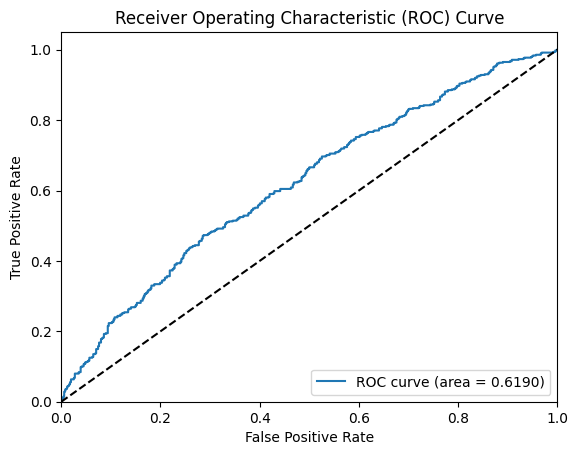

In [32]:
# Plot ROC curve and calculate AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [33]:
# Set Model To Train
model_full.to(device)

# Define optimizer
optimizer = AdamW(model_full.parameters(), lr=5e-5)

# Set Model to train
model_full.train()

# Training Loop
for epoch in range(3):  # Number of epochs
    for batch in train_dataloader:
        # Move batch to device
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Forward pass
        outputs = model_full(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss

        # Backward pass and optimization step
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1} completed")

print("Training complete")

/home/prakhar.k/project/conda/lib/python3.12/site-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1 completed
Epoch 2 completed
Epoch 3 completed
Training complete


In [41]:
# Print results:
model_full.eval()

# Function to calculate loss
def calculate_loss(dataloader):
    total_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model_full(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            total_loss += loss.item()
    return total_loss / len(dataloader)

# Calculate train and test cross-entropy loss
train_loss = calculate_loss(train_dataloader)
test_loss = calculate_loss(test_dataloader)

# Initialize variables for test metrics
all_preds = []
all_labels = []
all_probs = []

# Evaluation loop for test set
with torch.no_grad():
    for batch in test_dataloader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model_full(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        probs = torch.softmax(logits, dim=1)[:, 1].cpu().numpy()
        
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(probs)

# Calculate test metrics
accuracy = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
error_rate = 1 - accuracy

# Print metrics
print(f"Train Cross-Entropy Loss: {train_loss:.4f}")
print(f"Test Cross-Entropy Loss: {test_loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Error Rate: {error_rate:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Train Cross-Entropy Loss: 0.0314
Test Cross-Entropy Loss: 0.4150
Accuracy: 0.8480
Error Rate: 0.1520
Precision: 0.8320
Recall: 0.8627
F1 Score: 0.8471


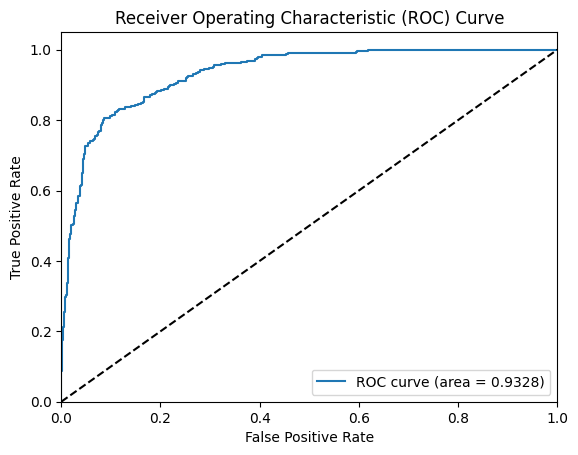

In [42]:
# Plot ROC curve and calculate AUC
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

import matplotlib.pyplot as plt
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Comments:

* Finetuning on all the layers gives a better accuracy than fintuning only on the final layer.
* Finetuning only on the final classification layer gives an accuracy no better than a guess at about 50%.
* Finetuning on all the layers gives us an accuracy of about 80%

### END